# Дипломный проект  «Модель прогнозирования стоимости жилья для агентства недвижимости»

Задача проекта следующая: агентство недвижимости столкнулось с проблемой — риелторы тратят слишком много времени на сортировку объявлений и поиск выгодных предложений. Поэтому скорость их реакции и качество анализа не дотягивают до уровня конкурентов. Это сказывается на финансовых показателях агентства.

Наша цель — разработать модель машинного обучения, которая поможет обрабатывать объявления и увеличит число сделок и прибыль агентства.

## Импорт библиотек

In [402]:
import pandas as pd
import seaborn as sns
import re
import numpy as np
import  matplotlib.pyplot as plt
import shap
import category_encoders
import pickle

from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from category_encoders import BinaryEncoder
from flask import Flask
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import feature_selection
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn import ensemble
from scipy.stats import normaltest
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV


## Подгрузка и знакомство с данными

In [403]:
data = pd.read_csv('data/data 3.csv')
data.head(5)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [404]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

## Работа с признаками

### 1. Признак target

Начнем обработку признаков с целевого признака *"target"* — цена объекта недвижимости. Посмотрим на количество пропусков и на то, как выглядят значения в данном признаке:

In [405]:
print(f'Количество пропусков: {data.target.isnull().sum()}\n'
       f'Топ-10 наиболее популярных значений: {data.target.value_counts().nlargest(7)} \n')

Количество пропусков: 2481
Топ-10 наиболее популярных значений: $225,000    1462
$275,000    1355
$250,000    1312
$350,000    1296
$299,900    1276
$325,000    1244
$249,900    1241
Name: target, dtype: int64 



Признак имеет тип object и содержит значок доллара. Преобразуем признак. Создадим функцию *get_numeric_target()*, которая будет преобразовывать данные в числовой формат:

In [406]:
def get_numeric_target(arg):
    
    """Функция принимает на вход целевой признак target и преобразовывает его в числовой формат.
    В случае пустого значения признака функция возвращает np.NaN"""
    
    arg = str(arg)
    number_list = re.findall('[0-9]+', arg)
    if number_list == []:
        return np.NaN
    else:
        result = ''
        for i in number_list:
            result = result + i
        return float(result)

In [407]:
#Применим функцию к признаку
data['target'] = data['target'].apply(lambda x: get_numeric_target(x)) 


Посмотрим на распределение признака:

<AxesSubplot: ylabel='target'>

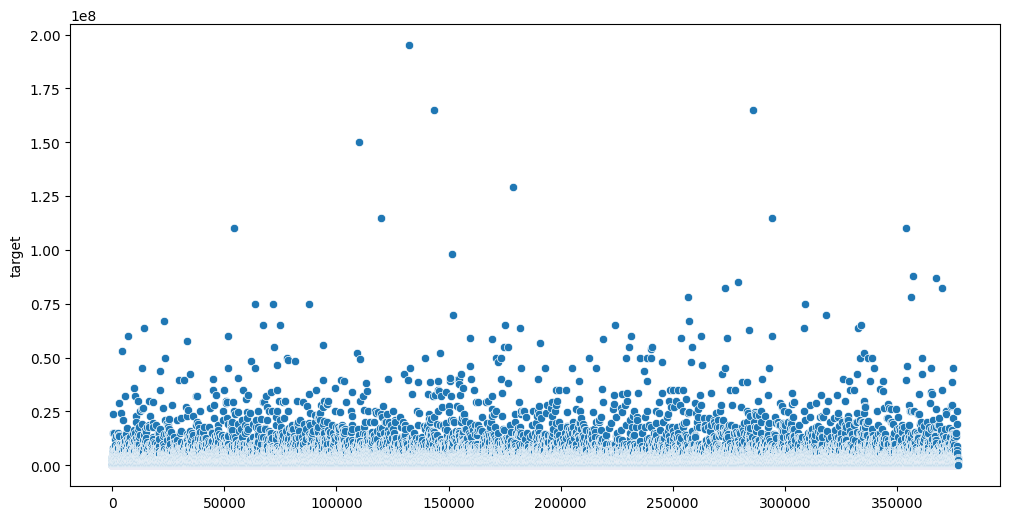

In [408]:
sns.scatterplot(data['target'])

Видно, что в признаке есть выбросы, но удалением выбросов займемся поезже. А пока посмотрим на пропущенные значения:

In [409]:
print(f'Количество пропущенных значений:{data.target.isnull().sum()}')

Количество пропущенных значений:2481


Пропущенных значений не очень много. Так как это целевой признак, лучше удалим такие записи из датасета:

In [410]:
data.dropna(axis=0,subset=['target'],inplace=True)
data['target'].isnull().sum()

0

### 2. Признак propertyType

Признак 'propertyType' означает тип объекта недвижимости. Выведем основную статистическую информацию о признаке:

In [411]:
print(f'Количество пропусков: {data.propertyType.isnull().sum()}\n'
      f'Количество уникальных значений: {data.propertyType.nunique()}\n'
       f'Топ-10 наиболее популярных значений: {data.propertyType.value_counts().nlargest(7)} \n')

Количество пропусков: 34554
Количество уникальных значений: 1279
Топ-10 наиболее популярных значений: single-family home    91376
Single Family         61888
Single Family Home    31725
condo                 25878
lot/land              20532
Condo                 16494
townhouse             11443
Name: propertyType, dtype: int64 



Попробуем привести все записи к нижнему регистру, возможно количество уникальных значений сократится.

In [412]:
data['propertyType'] = data['propertyType'].str.lower()

In [413]:
print(f'Количество уникальных значений: {data.propertyType.nunique()}')

Количество уникальных значений: 1271


In [414]:
data['propertyType'].sort_values(ascending=False).unique().tolist()

['yes',
 'warehouse',
 'walk-out ranch',
 'villa',
 'victorian/federal',
 'victorian, craftsman',
 'victorian, bilevel',
 'victorian',
 'urban contemporary',
 'unknown',
 'two story, tri-level',
 'two story, split-level',
 'two story, spanish/mediterranean',
 'two story, low rise',
 'two story, duplex',
 'two story',
 'tuscan',
 'tudor/provincial',
 'tudor',
 'triplex',
 'trinity',
 'tri-level, traditional',
 'tri-level, northwestern contemporary',
 'tri-level, modern',
 'tri-level, craftsman',
 'tri-level, contemporary',
 'tri-level',
 'transitional, williamsburg',
 'transitional, colonial',
 'transitional',
 'traditional, zero-lot line',
 'traditional, williamsburg',
 'traditional, victorian',
 'traditional, transitional, williamsburg',
 'traditional, transitional, cottage',
 'traditional, transitional',
 'traditional, texas hill country',
 'traditional, straight thru',
 'traditional, loft with bedrooms',
 'traditional, federal',
 'traditional, cottage',
 'traditional, contemporary',

Как видим, уникальных значений очень много. В данном признаке через запятую перечислены значения. Чтобы избавиться от большого количества уникальных значений, поступим следущим образом. Возьмем только первую часть значения (до первой запятой). Также есть значения вроде tudor/provincial, которые разделены /, также обрежем их. После этого объединим оставшиеся типы в общие группы, для этого заведем словарь.

In [415]:
data['propertyType'] = data['propertyType'].str.split(',').str[0]
data['propertyType'] = data['propertyType'].str.split('/').str[0]
print('Число уникальных значений:', data['propertyType'].nunique())
data['propertyType'].unique()

Число уникальных значений: 241


array(['single family home', 'single-family home', 'lot', 'townhouse',
       'florida', nan, 'single family', 'coop', 'english', '2 story',
       'multi-family', 'penthouse', 'multi-family home', 'condo', 'land',
       ' ', 'detached', '1 story', 'other style', 'colonial',
       'transitional', 'high rise', 'mobile', 'tri-level', 'craftsman',
       'single detached', 'federal', 'multi family', 'traditional',
       'custom', 'cooperative', 'contemporary', 'cape cod', 'mobile ',
       'miscellaneous', 'mfd', 'bungalow', 'spanish', 'multi-level',
       '2 stories', 'ranch', 'low-rise (1-3 stories)', 'rancher',
       'urban contemporary', 'two story', 'garden home', 'farms',
       'a-frame', 'attached or 1', 'one story', 'georgian',
       'dwelling with rental', 'victorian', 'apartment', 'cluster home',
       'manufactured house', 'other', 'condominium (single level)',
       'condominium (2 levels)', 'hi ranch', 'mediterranean',
       'garden apartment', 'cabin', 'bermuda', '

In [416]:
propertytype_dict = {
    'single_family_home': [
        'single family','single family home', 'single-family home', '1 story', '2 story', 'detached', '1 story', '1 story traditional', 'single detached', 'singlefamilyresidence', 'single wide', 'single-wide mobile with land',
        'two story', 'one story', 'one level unit', 'rancher', '1 1', 'single wide mh', 'one story traditional'],
    'multi_family_home': [
        'multi-family', 'multi-family home', 'duplex', 'triplex', 'attached duplex', 'fourplex', 'multi_level', 'multi family', '2 unit condo', '2-story'],
    'condo': [
        'condo', 'coop', 'cooperative', 'condominium', 'apartment', 'co-op', '2 story condo', 'high rise'],
    'townhouse': [
        'townhouse', 'townhome style', 'townhouse-interior', 'townhouse-end unit'],
    'apartment': [
        'apartment', 'condominium (single level)', 'high-rise', 'mid-rise', 'low-rise (1-3 stories)', 'Flats', 'studio'],
    'land': [
        'lot', 'land'],
    'mobile_home': [
        'mobile/manufactured', 'manufactured house', 'mfd', 'mobile home', 'manufactured home', 'manufactured double-wide', 'manufactured single-wide', 'mobile home 1 story', 'mobile manu - double wide'],
    'miscellaneous': [
        'miscellaneous'],
    'ranch': [
        'ranch', 'one story', 'high ranch', 'hi ranch'],
    'modern': [
        'contemporary', "modern", 'mid-century modern', 'mountain contemporary', 'urban contemporary', 'modern farmhouse', 'modernist', 'new build 2019'],
    'historical': [
        'historical', 'designated historical home', 'historic vintage', 'old style', 'historic'],
    'coastal': [
        'coastal', 'coastal contemporary', 'coastal ii', 'coastal modern', 'coastal two story'
    ],
    'other': [
        'Other', 'english', 'other style', 'florida', 'farms', 'carriage house', 'country english', 'straight thru', 'less than 4 floors', 'bungalow', 'custom', 'arts & crafts', 'tudor',  'split foyer', 'cottage', 'garden home', 'farm', 'farm house',  'farmhouse', 'houseboat', 'ground floor', 'victorian', '3 story', '3+ stories', 'santa barbara',  'modular', 'post and beam', 'manuf', 'multiple occupancy', 'attached', 'hawaiian plantation', 'forest garden home', 'split-entry', 'texas hill country', 'lake house', '1 story with basement', 'hi-rise', 'coastal beach home',  'key west', 'loft', 'english manor', 'mid-rise (4-7 stories)', 'mid-level', 'new englander', 'residential (<1 acre)', 'residential (1+ acre)', 'split', 'split level', 'split (4 level)', 'split (5+ level)', 'urban', 'patio', 'patio home', 'penthouse', 'manor', 'victorian',  'key west',  'end unit']
}

In [417]:
def propertytype_rename(arg):
    
    """ Функция принимает на вход признак 'propertyType' и сопоставляет ему новое обобщенное значение 'propertyType' в соответствии со словарем propertytype_dict.
    В случае отсутствия значения в словаре функция присваивает значение 'other' """
    
    for key, value in propertytype_dict.items():
        
        if arg in value:
            
            return key
        
    return 'other'

#применяем функцию к признаку:
data['propertyType'] = data['propertyType'].apply(propertytype_rename)

Проверим, не осталось ли пустых значений и посмотрим, как выглядит 'propertyType' после преобразования:

In [418]:
print(f'количество пропусков:{data.propertyType.isna().sum()}')

количество пропусков:0


In [419]:
data.propertyType.value_counts()

single_family_home    194111
condo                  57602
other                  53852
land                   31465
townhouse              18503
multi_family_home      12311
modern                  3379
ranch                   2052
mobile_home              866
apartment                384
miscellaneous             88
historical                66
coastal                   25
Name: propertyType, dtype: int64

Пропусков нет. Всего получилось 13 значений признака. 
Переходим к следущему признаку.

### 3. Признак baths

Признак *'baths'* означает количество ванных комнат. выведем основуную статистическую информацию:

In [420]:
print(f'Количество пропусков: {data.baths.isnull().sum()}\n'
      f'Количество уникальных значений: {data.baths.nunique()}\n'
       f'Топ-10 наиболее популярных значений: {data.baths.value_counts().nlargest(7)} \n')

Количество пропусков: 105376
Количество уникальных значений: 226
Топ-10 наиболее популярных значений: 2 Baths    52080
3 Baths    35396
2          20429
2.0        16355
4 Baths    14724
3.0        10797
3          10093
Name: baths, dtype: int64 



Очень большое количество пропусков. Посмотрим, сколько процентов занимают пропуски в данных, а также к каким PropertyType относятся пропуски:

In [421]:
print(f'Процент проупсков: {round(data.baths.isnull().sum() / data.baths.shape[0] * 100, 2)}%')

Процент проупсков: 28.12%


In [422]:
data[data['baths'].isnull()]['propertyType'].value_counts()

other                 39882
land                  27154
single_family_home    18456
condo                 11920
multi_family_home      2307
modern                 2302
townhouse              1544
ranch                  1537
apartment               141
mobile_home              72
historical               34
coastal                  22
miscellaneous             5
Name: propertyType, dtype: int64

In [423]:
data.baths.unique()

array(['3.5', '3 Baths', '2 Baths', '8 Baths', nan, '2', '3',
       'Bathrooms: 2', '1,750', '4 Baths', '2 ba', 'Bathrooms: 5',
       '1,000', '7 Baths', '2.0', '3.0', 'Bathrooms: 1', '4.0',
       '2.1 Baths', '2.5 Baths', '1', 'Bathrooms: 3', '4.5', '6 Baths',
       'Bathrooms: 4', '3 ba', '5', '2,500', '5.5 Baths', '1.0',
       '5 Baths', '1.5', '4', '~', '2.5', '4,000', '3.5 Baths', '2,000',
       '3,000', '8.0', '1 ba', '0', '5.0', '1,500', '7.0', '1,250',
       '9 Baths', '2,250', '6.0', '12 Baths', '5.5', '3,500', '1.5 Baths',
       '2,750', 'Bathrooms: 6', '4.5 Baths', '750', '5.5+', '6',
       '10 Baths', '6 ba', 'Bathrooms: 19', '10.0', '4 ba', '12 ba',
       '2.5+', '8', '7.5+', 'Bathrooms: 10', '0 / 0', 'Sq. Ft. ', '5 ba',
       '4.5+', '18 Baths', '-- baths', 'Bathrooms: 7', '7', '18', '3.5+',
       '1.5+', '11 Baths', '5,000', '1.75 Baths', '9', '12.0', '6.5',
       'Bathrooms: 8', '10', '19 Baths', 'Bathrooms: 9', '16 Baths',
       '13 Baths', 'Bathrooms: 13

226 уникальных значений, не так уж много. Займемся преобразованием признака, конечная цель - получить численное значение количества ванных для каждого объекта.

Первым делом удалим всю буквенную часть признака, а также знаки препинания и лишние пробелы ('+', ' ', '~', '--'  и прочее):

In [424]:
data['baths'] = data['baths'].str.replace('[a-zA-Z]','', regex=True)
data['baths'].replace(['. . ',''],0,inplace=True)
data['baths'] = data['baths'].str.replace(' ','', regex=True)
data['baths'] = data['baths'].str.replace('+','', regex=True)
data['baths'] = data['baths'].str.replace('--', '0', regex=True)
data['baths'] = data['baths'].str.replace(':', '', regex=True)
data['baths'] = data['baths'].str.replace('0/0', '0', regex=True)
data['baths'] = data['baths'].str.replace('~', '0', regex=True)

Также в данных присутствует объекты с тысячами ванных, посмотрим выборочно на такие объекты:

In [425]:
data[(data['baths'] == '5,000') | (data['baths'] == '4,000')].head(6)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
182,Active,NaN,single_family_home,1110 Midnight Dr,"4,000","{'atAGlanceFacts': [{'factValue': '2018', 'fac...",NaN,San Antonio,"[{'rating': ['10', '10', '8'], 'data': {'Dista...","3,097",78260,Baths,TX,NaN,NaN,NaN,1406976,470000.0
690,Active,NaN,single_family_home,2011 Chaffin Way,"4,000","{'atAGlanceFacts': [{'factValue': '2016', 'fac...",NaN,San Antonio,"[{'rating': ['8', 'NR', 'NR', 'NR', '8'], 'dat...","2,065",78260,Baths,TX,NaN,NaN,NaN,1416358,333900.0
3415,Active,NaN,other,28711 Estin Hts,"4,000","{'atAGlanceFacts': [{'factValue': '2019', 'fac...",1,San Antonio,"[{'rating': ['8', 'NR', 'NR', 'NR', '8'], 'dat...","3,981",78260,Baths,TX,NaN,NaN,NaN,1407607,599900.0
3847,Active,NaN,single_family_home,16684 Williams St,"5,000","{'atAGlanceFacts': [{'factValue': '2006', 'fac...",NaN,Thornton,"[{'rating': ['8', '7', '6'], 'data': {'Distanc...","3,765",80602,Baths,CO,NaN,NaN,NaN,899207,514000.0
5443,Active,NaN,modern,7825-SUITE 215 Tuckerman Ln Unit THE BEECH,"5,000","{'atAGlanceFacts': [{'factValue': '2020', 'fac...",NaN,Potomac,"[{'rating': ['8', '9', '10'], 'data': {'Distan...","2,231",20854,Baths,MD,NaN,NaN,NaN,MDMC686888,925000.0
5638,Active,NaN,other,8301 Lakewood Ridge Cv,"5,000","{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Austin,"[{'rating': ['8', '10', '8'], 'data': {'Distan...",NaN,78738,Baths,TX,NaN,NaN,NaN,8063568,349000.0


Видим, что цена объекта не соответсвует такому большому количеству ванных комнат, приходим к выводу, что это просто такой формат записи, и 4,000 - это, скорее всего, 4 ванных, 5,000 - 5 ванных комнат и тд. Сделаем замену:

In [426]:
data['baths'] = data['baths'].str.replace('1,000','1', regex=True)
data['baths'] = data['baths'].str.replace('2,500','2.5', regex=True)
data['baths'] = data['baths'].str.replace('3,500','3.5', regex=True)
data['baths'] = data['baths'].str.replace('5,000','5', regex=True)
data['baths'] = data['baths'].str.replace('2,750','2.75', regex=True)
data['baths'] = data['baths'].str.replace('7,500','7.5', regex=True)
data['baths'] = data['baths'].str.replace('1,250','1.25', regex=True)
data['baths'] = data['baths'].str.replace('4,000','4', regex=True)
data['baths'] = data['baths'].str.replace('1,500','1.5', regex=True)
data['baths'] = data['baths'].str.replace('2,000','2', regex=True)
data['baths'] = data['baths'].str.replace('3,000','3', regex=True)
data['baths'] = data['baths'].str.replace('2,250','2.25', regex=True)
data['baths'] = data['baths'].str.replace('1,750','1.75', regex=True)

Также присутствует записи вида '1-0/1-0/1', '3-1/2-2' и тд. Посмотрим на эти записи:

In [427]:
data[(data['baths'] == '1-0/1-0/1') | (data['baths'] == '116/116/116') | (data['baths'] == '2-1/2-1/1-1/1-1') | (data['baths'] == '1/1-0/1-0/1-0') | (data['baths'] == '3-1/2-2') | (data['baths'] == '1/1/1/1')| (data['baths'] == '1-2')]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
24724,Active,NaN,multi_family_home,1811 Beechwood Ave,1-0/1-0/1,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",NaN,Nashville,"[{'rating': ['6', '5', '3', '4', '5', 'NR', 'N...",2932,37212,3.0,TN,2.00,NaN,NaN,2081563,775000.0
63514,Active,NaN,multi_family_home,321 Larkin Springs Rd,116/116/116,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Madison,"[{'rating': ['1', 'NR', '3', '1', '2', '1', 'N...",99999,37115,NaN,TN,2.00,NaN,NaN,2051320,1600000.0
85359,Active,NaN,multi_family_home,6511 Robertson Ave,3-1/2-2,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Nashville,"[{'rating': ['2', '4', '3', '3', '2', 'NR', 'N...",1939,37209,3.0,TN,3.00,NaN,NaN,2085088,5750000.0
110097,Active,NaN,multi_family_home,3317 Ezell Rd,1/1/1/1,"{'atAGlanceFacts': [{'factValue': '1950', 'fac...",NaN,Nashville,"[{'rating': ['2', '3', '2', '1', '2', '2', 'NR...",4408,37211,3.0,TN,1.00,NaN,NaN,2027355,985000.0
301176,Active,NaN,multi_family_home,214 3rd Ave,2-1/2-1/1-1/1-1,"{'atAGlanceFacts': [{'factValue': '1900', 'fac...",NaN,Nashville,"[{'rating': ['1', '2', '3', '1', '4', '10', 'N...",11740,37201,2.0,TN,5.00,NaN,NaN,2107281,7450000.0
316488,Active,NaN,multi_family_home,126 Welworth St,1/1-0/1-0/1-0,"{'atAGlanceFacts': [{'factValue': '1966', 'fac...",NaN,Madison,"[{'rating': ['3', '2', '3', '1', '2', '1', 'NR...",1324,37115,2.0,TN,1.00,NaN,NaN,2094893,2250000.0
330468,for rent,NaN,condo,The Collette Apartments in Dallas,1-2,"{'atAGlanceFacts': [{'factValue': '1964', 'fac...",NaN,Dallas,"[{'rating': ['5/10', '5/10', '5/10'], 'data': ...",610-840 sqft,75206,1-2 Beds,TX,NaN,NaN,NaN,NaN,12151437.0


Удалим объект с записью '116/116/116', тк объект странный, признак sqft в данном объекте тоже заполен странным значением 99999. 

Сложно понять, что означают записи  вида, 1/1-0/1-0/1-0, можно только догадываться. Будем исходить из предположения, в записях содержится информация об этажах, на которых располагаются ванные, например запись  '3-1/2-2' означает, что 2 ванной находятся на 2 этаже, 1 ванная на 3 этаже и тд. Сделаем таким образом замену:

In [428]:
data['baths'] = data['baths'].str.replace('1/1/1/1','4', regex=True)
data['baths'] = data['baths'].str.replace('3-1/2-2','3', regex=True)
data['baths'] = data['baths'].str.replace('1/1-0/1-0/1-0','4', regex=True)
data['baths'] = data['baths'].str.replace('2-1/2-1/1-1/1-1','4', regex=True)
data['baths'] = data['baths'].str.replace('1-2','1', regex=True)
data['baths'] = data['baths'].str.replace('1-0/1-0/1','3', regex=True)


In [429]:
data['baths'] = data['baths'].drop(data[data['baths'] == '116/116/116'].index)

Заполним пропуски значением '0', а затем передем признак в числовой формат:

In [430]:

data['baths'] = data['baths'].str.replace('—','0', regex=True)
data['baths'] = data['baths'].fillna(0)
data['baths'].replace([''],0,inplace=True)

In [431]:
data.baths.unique()

array(['3.5', '3', '2', '8', 0, '1.75', '4', '5', '1', '7', '2.0', '3.0',
       '4.0', '2.1', '2.5', '4.5', '6', '5.5', '1.0', '1.5', '0', '8.0',
       '5.0', '7.0', '1.25', '9', '2.25', '6.0', '12', '2.75', '750',
       '10', '19', '10.0', '7.5', '18', '11', '12.0', '6.5', '16', '13',
       '14', '9.0', '8.5', '1.1', '17', '241', '16.0', '10.5', '11.0',
       '20', '40', '14.0', '24', '22.0', '0.00', '3.1', '3.25', '22',
       '32', '18.0', '0.0', '27', '26', '9.5', '15', '35', '3.75', '29',
       '21', '5.2', '14.5', '76', '13.0', '15.0', '23', '43', '34', '2.2',
       '55.0', '25', '12.5', '44', '0.5', '4.25', '4.75', '0.75', '4.1',
       '5.25', '41.0', '36', '30', '24.0', '23.0', '28', '34.0', '64.0',
       '11.5', '39', '30.0', '17.0', '42', '3.2', '20.0', '60', '6.75',
       '68', '44.0'], dtype=object)

In [432]:
data['baths'] = data['baths'].astype(float).round()

Передем к следующему признаку.

### 4.Признак fireplace

Признак 'fireplace' означает наличие камина. Вывыдем основную статистичекую информацию по признаку:

In [433]:
print(f'Количество пропусков: {data.fireplace.isnull().sum()}\n'
      f'Количество уникальных значений: {data.fireplace.nunique()}\n'
       f'Распределение значений: {data.fireplace.value_counts()}')

Количество пропусков: 272182
Количество уникальных значений: 1653
Распределение значений: yes                                                                     50018
Yes                                                                     20619
1                                                                       14533
2                                                                        2432
Not Applicable                                                           1990
                                                                        ...  
Free-standing, Insert, Wood                                                 1
Wood Burning, Attached Fireplace Doors/Screen, Electric, Gas Starter        1
One, Living Room                                                            1
FAMILYRM, Great Room, Living Room                                           1
Ceiling Fan, SMAPL, Utility Connection, Walk-In Closets                     1
Name: fireplace, Length: 1653, dtype: int64


Видим очень большое количество пропусков. Будем исходить из преположения, что пропущенное значение означает отсутствие камина в объекте. Посмотрим на процент пропусков далее заполним пропуски значением '0':

In [434]:
print(f'Процент проупсков: {round(data.fireplace.isnull().sum()/data.fireplace.shape[0] * 100, 2)}%')

Процент проупсков: 72.64%


In [435]:
data['fireplace'] = data['fireplace'].fillna(0)

Сделаем признак булевым. Значение '0' будет означать отстутсвтие камина,  '1' - наличие камина. Для этого создадим функцию *fireplace_checking()*:

In [436]:
def fireplace_checking(arg):
    """ Функция принимает на вход признак 'fireplace' и сопоставляет ему булево значение: 0 - если 'fireplace' уже заполнено нулем, либо в признаке явно указано отсутствие камина.
    В противном случае функция присваивает значение '1' """
    
    exeption_list = ['Not Applicable', 'No', '0', 'N/K', 'No Fireplace', 0]
    
    if (arg!=0) and (arg not in exeption_list):
        return 1
    else:
        return 0

In [437]:
#применим функцию к признаку fireplace_checking()
data['fireplace'] = data['fireplace'].apply(lambda x: fireplace_checking(x))

In [438]:
#Посмотрим, что получилось:
data['fireplace'].value_counts()

0    274788
1     99916
Name: fireplace, dtype: int64

Переходим к следующему признаку.

### 5. Признаки 'PrivatePool' и 'private pool'

Два признака 'PrivatePool' и 'private pool' означают одно и то же — наличие собственного бассейна. как связаны эти признаки, пока не очень понятно. Посмотрим на основную статистическую информацию по признакам:

In [439]:
print(f'Количество пропусков в PrivatePool: {data.PrivatePool.isnull().sum()}\n'
      f'Количество уникальных значений в PrivatePool: {data.PrivatePool.nunique()}\n'
       f'Распределение значений в PrivatePool: {data.PrivatePool.value_counts()}')

Количество пропусков в PrivatePool: 334583
Количество уникальных значений в PrivatePool: 2
Распределение значений в PrivatePool: yes    28687
Yes    11434
Name: PrivatePool, dtype: int64


In [440]:
#Переименуем 'private pool' для удобства:
data = data.rename(columns={'private pool': 'privatepool'})

In [441]:
print(f'Количество пропусков в PrivatePool: {data.privatepool.isnull().sum()}\n'
      f'Количество уникальных значений в PrivatePool: {data.privatepool.nunique()}\n'
       f'Распределение значений в PrivatePool: {data.privatepool.value_counts()}')

Количество пропусков в PrivatePool: 370553
Количество уникальных значений в PrivatePool: 1
Распределение значений в PrivatePool: Yes    4151
Name: privatepool, dtype: int64


Оба признакой содержать очень большое количество пропусков. Сделаем признаки булевыми: в случае пропуска заполним признак нулем, в противном случае единицей.

In [442]:
data['privatepool'] = data['privatepool'].fillna(0)
data['PrivatePool'] = data['PrivatePool'].fillna(0)

In [443]:
data['PrivatePool'] = data['PrivatePool'].replace(['yes', 'Yes'], 1)
data['privatepool'] = data['privatepool'].replace('Yes', 1)
data['privatepool'].value_counts()

0    370553
1      4151
Name: privatepool, dtype: int64

Посмотрим на пересечение значений в признаке:

In [444]:
data[(data['privatepool'] == 1) & (data['PrivatePool'] == 1)]

,status,privatepool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target


Пересечения нет. Создадим новый признак, который будет принимать 1, если хотя бы в одном из двух признаков 'privatepool' или 'PrivatePool' указано наличие камина:

In [445]:
data['Private_pool'] = data['PrivatePool'] + data['privatepool']
data['Private_pool'].value_counts()

0    330432
1     44272
Name: Private_pool, dtype: int64

In [446]:
#удалим исходные принаки
data = data.drop(['PrivatePool','privatepool'], axis=1)

Переходим к следующему признаку.

### 5. Признак Status

Признак *'status'* означает статус продажи. Выведем основную статистическую информацию по признаку:

In [447]:
print(f'Число уникальных значений:{data.status.nunique()}\n'
      f'Количество пропусков:{data.status.isnull().sum()}\n'
      f'Топ-10 значений:{data.status.value_counts().nlargest(10)}\n')

Число уникальных значений:156
Количество пропусков:39257
Топ-10 значений:for sale                     156100
Active                       105206
For sale                      43465
foreclosure                    5677
New construction               5459
Pending                        4697
Pre-foreclosure                2000
P                              1488
Pre-foreclosure / auction      1281
Under Contract Show            1183
Name: status, dtype: int64



Посмотрим на уникальные значения, их не очень много:

In [448]:
data['status'].unique().tolist()

['Active',
 'for sale',
 nan,
 'New construction',
 'New',
 'For sale',
 'Pending',
 'P',
 'Active/Contingent',
 ' / auction',
 'Under Contract',
 'Pre-foreclosure / auction',
 'Under Contract   Showing',
 'Pre-foreclosure',
 'Under Contract Backups',
 'Active Under Contract',
 'foreclosure',
 'Foreclosed',
 'Option Pending',
 'Under Contract Show',
 'for rent',
 'Auction',
 'A Active',
 'Contingent',
 'Pending   Continue To Show',
 'Price Change',
 'Back on Market',
 'Active Option',
 'Foreclosure',
 'Coming soon: Nov 21.',
 'Contingent Finance And Inspection',
 'Coming soon: Dec 4.',
 'P Pending Sale',
 'Coming soon: Nov 23.',
 'Active With Contingencies',
 'Pending Ab',
 'Pf',
 'Contingent Show',
 'Contract P',
 'Contingent Take Backup',
 'Apartment for rent',
 'Backup Contract',
 'Option Contract',
 'Pending Continue To Show',
 'pending',
 'Pending Inspection',
 'Active Option Contract',
 'C',
 'Auction - Active',
 'Contingent   Show',
 'Pi',
 'Due Diligence Period',
 'Contract Con

Перейдем к обработке признака. Заполним пропуски значением 'unknown', а также переведем все значения к единому регистру, тк в данных есть, например значения 'For sale' и 'for sale', объединим их в единое значение:

In [449]:
data['status'].fillna('unknown', inplace=True)
data['status'] = data['status'].str.lower()

Из брифа к кейсу, пояснения к данным:

'foreclosed' ('foreclosure') — «лишён права выкупа». Это процесс, когда недвижимость переходит к кредитору из-за
неуплаты ипотеки заёмщиком. Продажа foreclosure-недвижимости
отличается от традиционных продаж.

➔ 'pre foreclosure' ('pre foreclosure auction') — «до выкупа»,
«аукцион до выкупа».

➔ 'under contract showing' ('under contract show', 'under
contract', 'active under contract') — предложение о покупке
уже сделано, но не принято продавцом окончательно, и
недвижимость продолжают показывать другим потенциальным
покупателям.

➔ 'under contract backups', 'active backup', 'backup contract' —
предложение о покупке уже сделано и принято продавцом,
однако он открыт для резервных предложений.

➔ 'contingency' — дополнительные обстоятельства (критерии,
которым должен соответствовать продавец/покупатель до
завершения сделки).

➔ 'contingency contract' — контракт на случай возникновения
дополнительных обстоятельств.

'active contingency' — сделка уже практически состоялась,
однако продавцу/покупателю для её завершения необходимо
выполнить какие-то условия.

➔ 'insp inspection contingency' — ситуация, когда покупатель
может официально проинспектировать объект недвижимости в
определённый период времени.

➔ 'pending escape clause' — договор, предполагающий свободный
выход сторон из него.

➔ 'pending backup wanted' — договор уже заключен, однако
продавец хочет продолжать показывать недвижимость другим
потенциальным покупателям и принимать резервные
предложения.

➔ 'pending take backups' — условие, предполагающее, что
продавец может принимать резерные предложения, если сделка
с текущим покупателем не состоится.

➔ 'pending continue show' — договор уже заключен, однако
продавец хочет продолжать показывать недвижимость другим
потенциальным покупателям на случай, если текущая сделка не
состоится.

➔ 'pending inspection' — «в ожидании инспекции».

➔ 'due diligence period' — период, в течение которого покупатель
имеет право проинспектировать недвижимость и изучить всю
важную для заключения сделки информацию.

➔ 'activated' — «активен», открыт для покупки.

➔ 'active with contract' — продавец уже принял предложение о
покупке, однако сделка ещё не закрыта.

➔ 'active with offer' — продавец принял предложение о покупке,
однако ищет резервные предложения на случай, если сделка с
текущим покупателем не состоится.

➔ 'active auction', 'auction active', 'auction' — продажа
недвижимости с помощью аукциона.

➔ cooling-off period — период, в течение которого покупатель
может расторгнуть договор после завершения сделки

Пользуясь этими сведениями и здравым смыслом, заменим значения - синонимы, тем самым сократив число уникальных значений признака.

In [450]:
data['status'] = data['status'].str.replace('pendingw/cont.','pendingwithcontingencies')

data['status']  = data['status'].str.replace('active-contingent','activecontingent') \
    .str.replace('active/contingent','activecontingent') \
        .str.replace('activecontingency','activecontingent') \
            .str.replace('activewithcontingencies','activecontingent')

data['status']  = data['status'].str.replace('/auction','auction') \
    .str.replace('active-auction','auction-active')

data['status'] = data['status'].str.replace('uundercontract','undercontract') \
    .str.replace('undercontractshowing','undercontractshow').str.replace('undercontract-show','undercontractshow') 

data['status'] = data['status'].str.replace('a active','active')

data['status'] = data['status'].str.replace(' ','').str.replace(',','')

data['status'] = data['status'].str.replace('^comingsoon.*','comingsoon', regex=True)

data['status'] = data['status'].str.replace('^sold.*','recentlysold', regex=True)
data['status'] = data['status'].str.replace('pf','pre-foreclosure', regex=True)

data['status'] = data['status'].str.replace('pendingbackupswanted','pendingtakebackups', regex=True) \
    .str.replace('pendingw/backupwanted','pendingtakebackups') \
        .str.replace('pending-backupofferrequested','pendingtakebackups') 

data['status'] = data['status'].str.replace('active-auction','auction-active', regex=True)

data['status'] = data['status'].str.replace('pendingw/cont.','pending-continuetoshow', regex=True) \
    .str.replace('pendingcontinuetoshowfinancing','pending-continuetoshow') \
        .str.replace('pendingsh','pending-continuetoshow') 
        
data['status'] = data['status'].str.replace('apartmentforrent','forrent', regex=True)\
        .str.replace('condoforrent','forrent') 
data['status'] = data['status'].str.replace('undercontractshowing','undercontractshow', regex=True)\
        .str.replace('undercontract-show','undercontractshow') \
                .str.replace('uccontinuetoshow','undercontractshow') 
data['status'] = data['status'].str.replace('uundercontract','undercontract', regex=True)
data['status'] = data['status'].str.replace('/auction','auction', regex=True)
data['status'] = data['status'].str.replace('activeoptioncontract','optioncontract', regex=True)

The default value of regex will change from True to False in a future version.


Посмотрим, сколько уникальных значений осталось:

In [451]:
data['status'].nunique()

87

Переходим к следующему признаку.

### 6. Признак zipсode

Признак zipсode означает почтовый индекс объекта недвижимости. Выведем основную статистическую информацию по признаку: 

In [452]:
print(f'Число уникальных значений: {data.zipcode.nunique()} \n'
       f'Количество пропусков: {data.zipcode.isnull().sum()}\n'
       f'Топ-10 наиболее популярных значений: {data.zipcode.value_counts().nlargest(10)} \n'
       f'Примеры уникальных значений: {data.zipcode.sort_values().unique()[:10]}')

Число уникальных значений: 4541 
Количество пропусков: 0
Топ-10 наиболее популярных значений: 32137    2139
33131    1561
34747    1488
78245    1383
34759    1333
33132    1327
33137    1306
78253    1279
78254    1228
33130    1168
Name: zipcode, dtype: int64 
Примеры уникальных значений: ['--' '0' '00000' '02108' '02109' '02110' '02111' '02113' '02114' '02115']


Некоторые индексы содержат в себе дополнительную четырехзначную приставку через дефис (например 27607-6632). Посмотрим, сколько таких записей и постараемся понять, что она означает.

In [453]:
print('Число записей, имеющих четырехзначную приставку:', data[data.zipcode.str.contains('.*-.*',na=False, regex=True)]['zipcode'].shape[0])
data[data.zipcode.str.contains('.*-.*',na=False, regex=True)]['zipcode'].head(5)

Число записей, имеющих четырехзначную приставку: 242


3654    27606-1626
5192    27607-6632
7155    27705-3261
7545    27603-2692
8586    27603-3986
Name: zipcode, dtype: object

Поиск информации в сети Интернет показал, что 4-значные приставки к основному 5-значному zip-коду используется для дополнительной идентификации географической идентификациии в пределеах 5-значной зоны доставки, например, городской квартал, группа квартир, отдельный получатель больших объемов почты или любая другая единица, которая может использоваться как дополнительный идентификатор для более эффективной сортировки. То есть, это дополнительная информация к основному zip-коду.
Оставим ее.

Также в данных присутствуют объекты с индексоами '--', '0', '00000'. Посмотрим на них:

In [454]:
data[(data['zipcode'] == '--') | (data['zipcode'] == '0') | (data['zipcode'] == '00000')]

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,MlsId,target,Private_pool
30261,active,land,Gates Canyon Rd,0.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",0,Vacaville,"[{'rating': ['7', '4', '6', '6', '10', '2'], '...",0,0,NaN,CA,NaN,NaN,21904829,380000.0,0
83522,new,other,Cornejo Ricardo Descalzi,0.0,"{'atAGlanceFacts': [{'factValue': '1995', 'fac...",0,Quito Ecuador,"[{'rating': [], 'data': {'Distance': [], 'Grad...",NaN,0,NaN,NY,NaN,NaN,3177007,470000.0,0
231282,newconstruction,other,0 N Gopher Canyon Rd,0.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",0,Bonsall,"[{'rating': ['7/10', '7/10', '3/10'], 'data': ...",NaN,--,449 acres,CA,NaN,OC19261036,NaN,60000000.0,0
235207,unknown,townhouse,1744 N Dixie Hwy # 1744,3.0,"{'atAGlanceFacts': [{'factValue': '2010', 'fac...",0,Fort Lauderdale,"[{'rating': ['3/10', '5/10', '7/10'], 'data': ...","2,043",--,3,FL,NaN,NaN,"1744, Fort Lauderdale, FL",425000.0,0
305572,forsale,land,000 U.S. Hwy 359,0.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",0,Laredo,"[{'rating': ['4/10'], 'data': {'Distance': ['7...","243,849 sqft",0,NaN,TX,NaN,NaN,20193508,1740000.0,0
308229,active,other,435 pescador,0.0,"{'atAGlanceFacts': [{'factValue': '1972', 'fac...",0,Foreign Country,"[{'rating': [], 'data': {'Distance': [], 'Grad...","1,100",00000,NaN,OS,NaN,NaN,CV18033361,125000.0,0


Их оказалось всего 6 штук, просто удалим такие записи:

In [455]:
data = data.drop(data[(data['zipcode'] == '--') | (data['zipcode'] == '0') | (data['zipcode'] == '00000')].index)
data.zipcode.nunique()

4538

Переходим к следующему признаку.

### 7. Признак city

Признак city означает город, в котором раположен объект недвижимости. Выведем основную статистическую информацию по признаку: 

In [456]:
print(f'Число уникальных значений: {data.city.nunique()} \n'
       f'Количество пропусков: {data.city.isnull().sum()}\n'
       f'Топ-10 наиболее популярных значений: {data.city.value_counts().nlargest(10)} \n'
       f'Примеры уникальных значений: {data.city.sort_values().unique()[:10]}')

Число уникальных значений: 2016 
Количество пропусков: 34
Топ-10 наиболее популярных значений: Houston         24407
San Antonio     15501
Miami           15411
Jacksonville     9892
Dallas           8771
Brooklyn         7246
New York         6905
Chicago          6894
Charlotte        6526
Las Vegas        5975
Name: city, dtype: int64 
Примеры уникальных значений: [' ' '--' 'ALTAMONTE SPRINGS' 'ANN ARBOR' 'APOPKA' 'ARCADIA' 'AURORA'
 'AVENTURA' 'Abilene' 'Abingdon']


Некоторые названия городов записаны по-разному, но означают один и тот же город. Например, 'New York City' и 'New York'.
Переименуем такие названия:

In [457]:
data['city'] = data['city'].str.replace('New York City','New York', regex=True) \
.replace('North pt','North port', regex=True) \
.replace({'Allentown City':'Allentown'}) \
.replace({'Anderson Twp':'Anderson Township'}) \
.replace({'Asheville City':'Asheville'}) \
.replace({'Atlaanta':'Atlanta'}) \
.replace({'Bainbridge Is':'Bainbridge Island'}) \
.replace({'Bay Harbor Is':'Bay Harbor Islands'}) \
.replace({'Bedford Hts':'Bedford Heights'}) \
.replace({'Bee Caves':'Bee Cave'}) \
.replace({'Belllingham':'Bellingham'}) \
.replace({'Bonita Spgs':'Bonita Springs'}) \
.replace({'College Pt':'College Point'}) \
.replace({'Columbia Twp':'Columbia Township'}) \
.replace({'Commercecity':'Commerce City'}) \
.replace({'Doctor Philips':'Doctor Phillips'}) \
.replace({'Fairfield Twp.':'Fairfield Twp'}) \
.replace({'Federalheights':'Federal Heights'}) \
.replace({'Ft Lauderdale':'Fort Lauderdale'}) \
.replace({'Ft Worth':'Fort Worth'}) \
.replace({'Ft. Worth':'Fort Worth'}) \
.replace({'Herkimer Ny':'Herkimer'}) \
.replace({'Hide A Way Hills':'Hideaway Hills'}) \
.replace({'High Pt':'High Point'}) \
.replace({'Hollywood Pa':'Hollywood Park'}) \
.replace({'Jamaica Est':'Jamaica Estates'}) \
.replace({'Jc':'Johnson City'}) \
.replace({'Lehigh':'Lehigh Acres'}) \
.replace({'Los Feliz L':'Los Angeles'}) \
.replace({'St Albans City':'St. Albans City'}) \
.replace({'Poughkeepsie City':'Poughkeepsie'}) \
.replace({'P C Beach':'Panama City Beach'}) \
.replace({'Allentown City':'Allentown'})

Переведем все данные к нижнему регистру, возможно число уникальных значений сократиться:

In [458]:
print(f'Число уникальных значений: {data.city.nunique()}')

Число уникальных значений: 1987


In [459]:
data['city'] = data['city'].str.lower()

Посмотрим на города, в которых на месте города указаны прочерки '--':

In [460]:
data[data['city'] == '--']

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,MlsId,target,Private_pool
15234,unknown,condo,8763 Worldquest Blvd # 5504,3.0,"{'atAGlanceFacts': [{'factValue': '2007', 'fac...",0,--,"[{'rating': ['5/10', '3/10', '6/10'], 'data': ...","1,450",32821,3,FL,NaN,NaN,"5504, FL 32821",155900.0,1
117070,unknown,other,1906 Milton,0.0,"{'atAGlanceFacts': [{'factValue': None, 'factL...",0,--,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...",NaN,33184,-- sqft,FL,NaN,NaN,A10674508,8500.0,0
120620,unknown,other,(undisclosed Address),0.0,"{'atAGlanceFacts': [{'factValue': None, 'factL...",0,--,"[{'rating': ['10/10', '3/10'], 'data': {'Dista...",NaN,33187,2.59 acres,FL,NaN,NaN,A10745666,399900.0,0
128298,unknown,single_family_home,19155 Moorgate St,0.0,"{'atAGlanceFacts': [{'factValue': 'No Data', '...",0,--,"[{'rating': ['5/10'], 'data': {'Distance': ['4...",NaN,32833,0,FL,NaN,NaN,F10162160,59900.0,0
273164,unknown,other,0 Island Lake Dr,0.0,"{'atAGlanceFacts': [{'factValue': None, 'factL...",0,--,"[{'rating': ['9/10', '4/10', '4/10'], 'data': ...",NaN,32226,-- sqft,FL,NaN,NaN,A10749811,89000.0,0
299284,unknown,other,35XX Sw # 158XX,0.0,"{'atAGlanceFacts': [{'factValue': None, 'factL...",0,--,"[{'rating': ['10/10', '7/10', '6/10'], 'data':...",NaN,33185,"7,261 sqft",FL,NaN,NaN,"158XX, FL 33185",35000.0,0
308855,unknown,other,0 Teal St,0.0,"{'atAGlanceFacts': [{'factValue': None, 'factL...",0,--,"[{'rating': ['2/10', '2/10', '3/10'], 'data': ...",NaN,32209,"6,216 sqft",FL,NaN,NaN,A10745301,9000.0,0
325918,newconstruction,townhouse,1613 W B St # 54,3.0,"{'atAGlanceFacts': [{'factValue': '2018', 'fac...",0,--,"[{'rating': ['7/10', 'NA', '4/10'], 'data': {'...","1,595 sqft",78501,3 bd,FL,NaN,A10518254,NaN,229000.0,0
362332,unknown,other,38XX Sw # 161XX,0.0,"{'atAGlanceFacts': [{'factValue': None, 'factL...",0,--,"[{'rating': ['10/10', '7/10', '6/10'], 'data':...",NaN,33185,"6,873 sqft",FL,NaN,NaN,"161XX, FL 33185",35000.0,0


Не так уж немного городов, заполним их самостоятельно. 

Воспользуемся ресурсом https://www.unitedstateszipcodes.org/33185/ и восстновим город по индексу вручную:

In [461]:
data.at[15234, 'city'] ='orlando'
data.at[117070, 'city'] ='miami'
data.at[120620,'city'] = 'miami'
data.at[128298,'city'] = 'orlando'
data.at[273164,'city'] = 'jacksonville'
data.at[299284,'city'] = 'miami'
data.at[308855,'city'] = 'jacksonville'
data.at[325918,'city'] = 'mcallen'
data.at[362332,'city'] = 'miami'


In [462]:
#Проверим, не осталось ли пррпусков:
data[data['city'] == '--']

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,MlsId,target,Private_pool


Перейдем к пропускам. Всего пропуска 34, также восстановим их вручную, пользуясь тем же самым ресурсом.

In [463]:
data[data.city.isnull()]

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,MlsId,target,Private_pool
7830,active,single_family_home,13155 W Highway 316,2.0,"{'atAGlanceFacts': [{'factValue': '2000', 'fac...",0,NaN,"[{'rating': ['1', '4', '3', '3', '6', '6'], 'd...",1016,32686,1,FL,2,NaN,A10445273,1495000.0,0
21529,active,land,SE 117th Ter,0.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",0,NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,32668,NaN,FL,NaN,NaN,F10183087,49900.0,0
26467,active,land,Blk 4 N America Lareedo Rd Lot 8,0.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",0,NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,78045,NaN,TX,NaN,NaN,20183582,417718.0,0
60994,active,land,Ocala,0.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",0,NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,34474,NaN,FL,NaN,NaN,F10011873,31334.0,0
81514,active,land,Unditermined Unditermined,0.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",0,NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,34432,NaN,FL,NaN,NaN,A10652556,28000.0,0
122345,active,land,Sw149 Ter,0.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",0,NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,34481,NaN,FL,NaN,NaN,A10697411,18000.0,0
123490,active,land,26484 Deer Rd,0.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",0,NaN,"[{'rating': ['6', '5', '7', '7', '2', '10', 'N...",0,33955,NaN,FL,NaN,NaN,A10326590,4000.0,0
130563,forsale,single_family_home,20003 Mar Rojo Y Mar Egeo,6.0,"{'atAGlanceFacts': [{'factValue': '2000', 'fac...",0,NaN,"[{'rating': ['5/10', 'NA', '4/10'], 'data': {'...","Total interior livable area: 5,905 sqft",20003,5 bd,MA,NaN,A10761803,NaN,1650000.0,1
131275,active,land,19212 Roosevelt,0.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",0,NaN,"[{'rating': ['5', '4', '6', 'NR', '5', 'NR', '...",0,33954,NaN,FL,NaN,NaN,A10741077,4200.0,0
151965,active,land,Ocala,0.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",0,NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,34474,NaN,FL,NaN,NaN,F10011860,31334.0,0


In [464]:
data.at[7830, 'city'] = 'reddick'
data.at[21529, 'city'] = 'morriston'
data.at[26467, 'city'] = 'laredo'
data.at[60994, 'city'] = 'ocala'
data.at[81514, 'city'] = 'dunnellon'
data.at[122345, 'city'] = 'ocala'
data.at[123490, 'city'] = 'punta gorda'
data.at[130563, 'city'] = 'washington'
data.at[131275, 'city'] = 'port charlotte'
data.at[151965, 'city'] = 'ocala'
data.at[170347, 'city'] = 'kissimmee'
data.at[171302, 'city'] = 'laredo'
data.at[186792, 'city'] = 'ocala'
data.at[199663, 'city'] = 'ocala'
data.at[215086, 'city'] = 'silver springs'
data.at[221281, 'city'] = 'laredo'
data.at[221870, 'city'] = 'laredo'
data.at[222802, 'city'] = 'ocala'
data.at[262351, 'city'] = 'cleveland'
data.at[270923, 'city'] = 'laredo'
data.at[277462, 'city'] = 'reddick'
data.at[278517, 'city'] = 'kissimmee'
data.at[282020, 'city'] = 'kissimmee'
data.at[304932, 'city'] = 'kissimmee'
data.at[309263, 'city'] = 'kissimmee'
data.at[312970, 'city'] = 'dunnellon'
data.at[325782, 'city'] = 'punta gorda'
data.at[331180, 'city'] = 'ocklawaha'
data.at[342346, 'city'] = 'laredo'
data.at[346292, 'city'] = 'miami'
data.at[355395, 'city'] = 'punta gorda'
data.at[358935, 'city'] = 'kissimmee'
data.at[370080, 'city'] = 'houston'
data.at[370507, 'city'] = 'ocklawaha'

In [465]:
data[data['city'].isna()]


,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,MlsId,target,Private_pool


Переходим к следующему признаку.

### 8. Признак state

Признак state означает штат, в котором раположен объект недвижимости. Выведем основную статистическую информацию по признаку: 

In [466]:
print(f'Число уникальных значений: {data.state.nunique()} \n'
       f'Количество пропусков: {data.state.isnull().sum()}\n'
       f'Топ-10 наиболее популярных значений: {data.state.value_counts().nlargest(10)} \n'
       f'Уникальные значения: {data.state.unique().tolist()}')

Число уникальных значений: 38 
Количество пропусков: 0
Топ-10 наиболее популярных значений: FL    114666
TX     83357
NY     24338
CA     23206
NC     21786
TN     18231
WA     13739
OH     12432
IL      8852
NV      8421
Name: state, dtype: int64 
Уникальные значения: ['NC', 'WA', 'CA', 'TX', 'FL', 'PA', 'TN', 'IA', 'NY', 'OR', 'DC', 'NV', 'AZ', 'GA', 'IL', 'NJ', 'MA', 'OH', 'IN', 'UT', 'MI', 'VT', 'MD', 'CO', 'VA', 'KY', 'MO', 'WI', 'ME', 'MS', 'OK', 'SC', 'MT', 'DE', 'Fl', 'BA', 'AL', 'OT']


Посмотрим на распределение количества лотов по штатам:

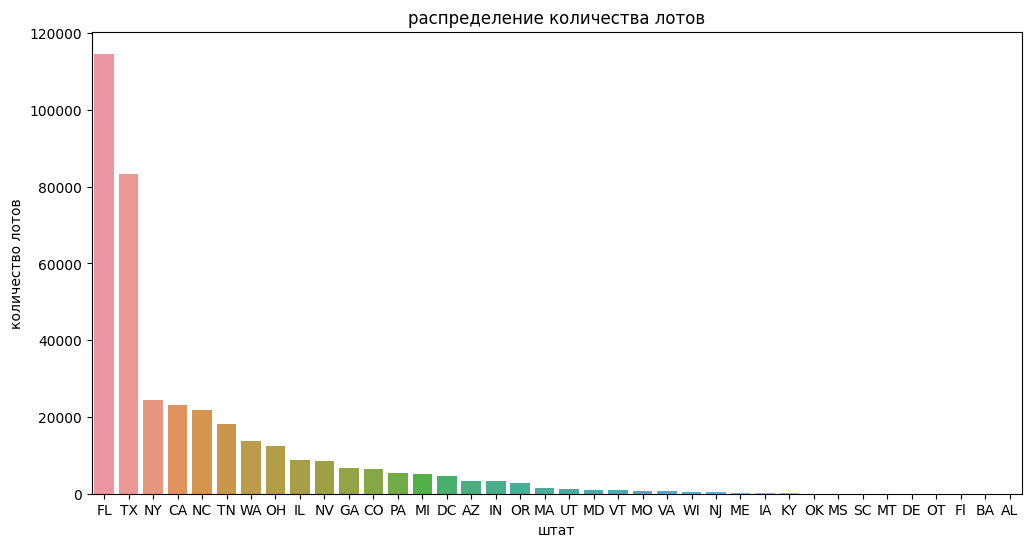

In [467]:
data['state'] = data['state'].astype("category")
order = data.value_counts('state')

plt.rcParams['figure.figsize'] = (12,6)
fig, ax = plt.subplots()
bar = sns.barplot(data = data, x="state", y='target', estimator=len, order=order.index)
bar.set_title("распределение количества лотов")
bar.set_xlabel("штат")
bar.set_ylabel("количество лотов")
plt.show()

К данному признаку совершенно нет вопросов, все заполнено идеально, пропуски отсутствуют. 

Переходим к следующему признаку.

### 9. Признак stories

Признак stories означает количество этажей объекта недвижимости. Выведем основную статистическую информацию по признаку: 

In [468]:
print(f'Число уникальных значений: {data.stories.nunique()} \n'
       f'Количество пропусков: {data.stories.isnull().sum()}\n'
       f'Топ-10 наиболее популярных значений: {data.stories.value_counts().nlargest(10)} \n'
       f'Примеры уникальных значений: {data.stories.sort_values().unique()[:10]}')

Число уникальных значений: 348 
Количество пропусков: 149788
Топ-10 наиболее популярных значений: 1.0    66808
2.0    55003
1      22795
2      17976
3.0    11233
0.0     7209
One     5758
0       4231
3       4201
9.0     2914
Name: stories, dtype: int64 
Примеры уникальных значений: [', 1' ', 2' ', 3' '0' '0.0' '1' '1 1/2 Levels' '1 1/2 Story' '1 Level'
 '1 Level, 1.5 Level']


Сразу бросается в глаза большое количество пропусков (149788). Посмотрим, сколько это в % от всех записей:

In [469]:
print(f'%% пропущенных значений в признаке: {round(100 * data.stories.isnull().sum() / data.shape[0], 1)}%')

%% пропущенных значений в признаке: 40.0%


Посмотрим, к какому типу PropertyType относятся пропуски:

In [470]:
data[data.stories.isnull()]['propertyType'].value_counts()

single_family_home    45823
other                 37875
land                  28898
condo                 24886
multi_family_home      5203
townhouse              3933
ranch                  1398
modern                 1256
mobile_home             281
apartment               158
historical               44
coastal                  25
miscellaneous             8
Name: propertyType, dtype: int64

Если пропуски, которые относятся к типам жилья 'land' (земля) или 'other' (иное) можно объяснить, то с типами жилья 'single_family_home' / 'condo' и другими нет. Слишком большой процент пропусков, лучше удалить этот признак:

In [471]:
data = data.drop('stories', axis=1)

Переходим к следующему признаку.

### 10. Признак Schools

Признак Schools означает сведения о школах в районе. Выведем основную статистическую информацию по признаку: 

In [472]:
print(f'Число уникальных значений: {data.schools.nunique()} \n'
       f'Количество пропусков: {data.schools.isnull().sum()}\n'
       f'Примеры уникальных значений: {data.schools.sort_values().unique()[:3]}')

Число уникальных значений: 295359 
Количество пропусков: 0
Примеры уникальных значений: ["[{'rating': [''], 'data': {'Distance': [], 'Grades': []}, 'name': []}]"
 "[{'rating': ['1', '1', '1', '1', '2', '5', 'NR', 'NR'], 'data': {'Distance': ['0.8 mi', '0.5 mi', '0.8 mi', '1.1 mi', '0.5 mi', '0.5 mi', '0.3 mi', '0.3 mi'], 'Grades': ['K–5', '6–8', '9–12', 'K–5', 'K–12', '9–12', 'K–8', 'K–8']}, 'name': ['Forty-Second Street Elementary School', 'Audubon Middle School', 'Crenshaw Science, Technology, Engineering, Math And Medicine Magnet School', 'Fifty-Fourth Street Elementary School', 'Marlton School', 'Crenshaw Arts-Technology Charter High School', 'Career Elementary Preparatory Academy Private School', 'Fortitude CCS Private School']}]"
 "[{'rating': ['1', '1', '1', '1', '2', 'NR', 'NR', 'NR'], 'data': {'Distance': ['0.1 mi', '0.9 mi', '0.5 mi', '0.4 mi', '0.5 mi', '0.5 mi', '0.5 mi', '0.5 mi'], 'Grades': ['K–5', '6–8', '9–12', 'K–5', 'K–12', '9–12', 'K–6', 'K–8']}, 'name': ['Coliseum S

Можем видеть, что признак 'schools' представляет собой словарь и
содержит следующие типы сведений:
- 'rating': [''] - рейтинги ближайших школ, 
- 'data': 
    - {'Distance': [] - расстояние до школы, 
    - 'Grades': [] - оценки школы}, 
- 'name':[] - название школы

Десериализем содержимое этих признаков. Создадим новые признаки: средний рейтинг школ вокруг объекта недвидиомти и расстояние до ближайшей школы.

### Работа с удаленностью школ

Десериализуем содержимое словаря, вытащив значение по ключу 'Distance':

In [473]:
school_distance = data.schools.str.findall(r"\bDistance': ([\s\S]+?), 'Grades\b")
school_distance

0         [['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10....
1                          [['1.65mi', '1.32mi', '1.01mi']]
2                          [['1.19mi', '2.06mi', '2.63mi']]
3                 [['1.05mi', '0.1mi', '1.05mi', '0.81mi']]
4                          [['5.96mi', '3.25mi', '3.03mi']]
                                ...                        
377180                              [['32.1 mi', '1.1 mi']]
377181                     [['10.61mi', '1.42mi', '0.4mi']]
377182                               [['0.48mi', '0.73mi']]
377183                     [['1.3 mi', '0.5 mi', '1.9 mi']]
377184                     [['0.3 mi', '1.1 mi', '4.1 mi']]
Name: schools, Length: 374698, dtype: object

Рассчитаем расстояние до брижайшей школы и создаздим новый признак 'min_school_distance'. Если данных об удаленности школ нет, заполним значением -1:

In [474]:
school_distance = school_distance.apply(lambda x: x[0])
school_distance = school_distance.str.findall(r'\b([0-9]+.[0-9]+)') #находим числовую часть
school_distance = school_distance.apply(lambda x: [float(i) for i in x]) #преобразуем в  float
min_school_distance = school_distance.apply(lambda x: -1 if len(x)==0 else min(x)) #заполняем -1, если список пуст, иначе берем минимальное расстояние
data['min_school_distance'] = min_school_distance #создаем новый признак

### Работа с рейтингом школ

Десериализуем содержимое словаря, вытащив значение по ключу 'rating'. Рассчитаем средний ретинг по школам и создаздим новый признак 'mean_school_rating'. Если данных по удаленности школ нет, заполним значением -1:

In [475]:
school_ratings = data.schools.str.findall(r"\brating': ([\s\S]+?), 'data\b")
school_ratings = school_ratings.apply(lambda x: x[0])
school_ratings = school_ratings.str.replace('/10','', regex=False)
school_ratings = school_ratings.str.findall(r'\b([0-9])\'')
school_ratings = school_ratings.apply(lambda x: [float(i) for i in x])
school_ratings = school_ratings.apply(lambda x: -1 if len(x)==0 else np.average([int(i) for i in x]))
school_ratings = round(school_ratings, 2)

In [476]:
data['mean_school_rating']= school_ratings

Удалим признак schools:

In [477]:
data = data.drop('schools', axis=1)

Переходим к следующему признаку.

### 11. Признак Street

Признак Street — адрес объекта. Выведем основную статистическую информацию по признаку: 

In [478]:
print(f'Число уникальных значений: {data.street.nunique()} \n'
       f'Количество пропусков: {data.street.isnull().sum()}\n'
       f'Топ-10 наиболее популярных значений: {data.street.value_counts().nlargest(10)} \n'
       f'Примеры уникальных значений: {data.street.sort_values().unique()[:10]}')

data.shape

Число уникальных значений: 334746 
Количество пропусков: 2
Топ-10 наиболее популярных значений: Address Not Disclosed    672
Undisclosed Address      516
(undisclosed Address)    391
Address Not Available    175
Unknown Address           72
2103 E State Hwy 21       57
11305 Gulf Fwy            54
17030 Youngblood Rd.      38
NE 58th Cir               34
9470 Lancaster Rd. SW     32
Name: street, dtype: int64 
Примеры уникальных значений: [' Starry St # 4A' '#1204 Plan, Waterfall on Lake Travis'
 '#1302 Plan in ONE Mission Bay' '#1307 Plan in ONE Mission Bay'
 '#1401 Plan in ONE Mission Bay' '#1501 Plan in Waterfall on Lake Travis'
 '#1504 Plan in Waterfall on Lake Travis'
 '#2301 Plan in Waterfall on Lake Travis' '#303 Plan in ONE Mission Bay'
 '#4 James Farm Rd #4 ']


(374698, 17)

В этом признаке очень много уникальных значений. Сделаем следующие преобразования: в признаке есть значения 'Unknown Address' / 'Address Not Disclosed' / 'Undisclosed Address' и другие, которые имеют один и тот же смысл - адрес объекта неизвестен. Заполним все эти значения значением 'unknown', а также приведем все записи в признаке к нижнему регистру, чтобы сократить %% уникальных значений:

In [479]:
data['street'] = data['street'].str.replace('Unknown Address','unknown', regex=True) \
.replace('Address Not Disclosed','unknown', regex=True) \
.replace({'Undisclosed Address':'unknown'}) \
.replace({'(undisclosed Address)':'unknown'}) \
.replace({'Address Not Available':'unknown'}) 

data['street'] = data['street'].str.lower()
data['street'] = data['street'].fillna('unknown')

In [480]:
print(f' Процент уникальных значений признака: {round(100 * data.street.nunique() / data.shape[0], 2)}%')

 Процент уникальных значений признака: 89.12%


Несмотря на преобразования процент уникальных значений признака слишком большой, удалим его.

In [481]:
data = data.drop('street', axis=1)

Переходим к селующему признаку.

### 12. Признак 'Sqft'

Признак 'sqft' — площадь объекта недвижимости в футах. Выведем основную статистическую информацию по признаку: 

In [482]:
print(f'Число уникальных значений: {data.sqft.nunique()} \n'
       f'Количество пропусков: {data.sqft.isnull().sum()}\n'
       f'Топ-10 наиболее популярных значений: {data.sqft.value_counts().nlargest(10)} \n'
       f'Примеры уникальных значений: {data.sqft.sort_values().unique()[:10]}')

Число уникальных значений: 25372 
Количество пропусков: 40120
Топ-10 наиболее популярных значений: 0             11852
1,200 sqft      829
1,000 sqft      648
1,100 sqft      570
1,800 sqft      562
1,500 sqft      544
--              535
2,000 sqft      521
1,400 sqft      516
1,600 sqft      452
Name: sqft, dtype: int64 
Примеры уникальных значений: ['--' '-- sqft' '0' '1' '1 sqft' '1,000' '1,000 sqft' '1,001' '1,001 sqft'
 '1,002']


Посмотрим на уникальные значения в признаке:

In [483]:
data.sqft.unique().tolist()

['2900',
 '1,947 sqft',
 '3,000 sqft',
 '6,457 sqft',
 nan,
 '897 sqft',
 '1,507',
 '3588',
 '1,930',
 '1,300 sqft',
 '3,130',
 '2,839 sqft',
 'Total interior livable area: 1,820 sqft',
 '2,454',
 '2,203',
 '3,325',
 '3,080 sqft',
 '1,612 sqft',
 '1,731 sqft',
 'Total interior livable area: 5,266 sqft',
 '1,080',
 '3,645 sqft',
 '1,953 sqft',
 '5,796 sqft',
 '2,575 sqft',
 '2,349 sqft',
 '935 sqft',
 '1736',
 'Total interior livable area: 1,677 sqft',
 '1,176 sqft',
 '1,085',
 '864 sqft',
 '900 sqft',
 '1,448 sqft',
 '1,396',
 'Total interior livable area: 1,232 sqft',
 '1,720 sqft',
 '2,388 sqft',
 '1,081 sqft',
 '1101',
 'Total interior livable area: 5,358 sqft',
 '1,683 sqft',
 '0',
 '1,200 sqft',
 '1,873',
 '1,908 sqft',
 '1,632 sqft',
 '4339',
 '1,681 sqft',
 '3,756 sqft',
 '1,504 sqft',
 '2,088 sqft',
 '1,076 sqft',
 '2,688',
 '1308',
 '2,200 sqft',
 '1,244 sqft',
 '2272',
 '770 sqft',
 '1,160',
 '3,928 sqft',
 'Total interior livable area: 2,383 sqft',
 '5131',
 '4,520 sqft',
 '

Преобразуем признак: отбросим числовую часть и знаки пунктуации:

In [484]:
notna_sqft = data.sqft[data.sqft.notna()]
notna_sqft = notna_sqft.str.findall(r"\d+")
notna_sqft = notna_sqft.apply(lambda x: ''.join(x))
data.loc[data.sqft.notna(), 'sqft'] = notna_sqft

Заполним пропуски и пустые строки значением "-1":

In [485]:
data.sqft = data.sqft.fillna(-1)    
data.loc[data.sqft=='','sqft'] = -1

Преобразуем признак в числовое значение:

In [486]:
data.sqft = data.sqft.astype(int)

Посмотрим на признак после преобразования:

In [487]:
data.sqft.value_counts().nlargest(5)

-1       40931
 0       11852
 1200     1411
 1000     1018
 1500     1010
Name: sqft, dtype: int64

Переходим к следующему признаку.

### 13. Признак 'beds'

Признак 'beds'  — количество спален  в объекте недвижимости. Выведем основную статистическую информацию по признаку: 

In [488]:
print(f'Число уникальных значений: {data.beds.nunique()} \n'
       f'Количество пропусков: {data.beds.isnull().sum()}\n'
       f'Топ-10 наиболее популярных значений: {data.beds.value_counts().nlargest(10)} \n'
       f'Примеры уникальных значений: {data.beds.sort_values().unique()[:10]} \n'
       f'%% пропущенных значений в признаке: {round(100 * data.beds.isnull().sum() / data.shape[0], 1)}%')

Число уникальных значений: 1146 
Количество пропусков: 90952
Топ-10 наиболее популярных значений: 3 Beds    53077
4 Beds    35225
3         31190
2 Beds    26196
4         19915
2         15998
Baths     15258
3 bd      12678
5 Beds    11227
4 bd       8193
Name: beds, dtype: int64 
Примеры уникальных значений: [' ' '# Bedrooms 1st Floor' '-- bd' '-- sqft' '0' '0.0' '0.25 acres'
 '0.26 acres' '0.27 acres' '0.28 acres'] 
%% пропущенных значений в признаке: 24.3%


In [489]:
print(f'%% пропущенных значений в признаке: {round(100 * data.beds.isnull().sum() / data.shape[0], 1)}%')

%% пропущенных значений в признаке: 24.3%


In [490]:
data.beds.unique().tolist()

['4',
 '3 Beds',
 '5 Beds',
 nan,
 '2 Beds',
 '3',
 '4 Beds',
 '3 bd',
 'Baths',
 '4 bd',
 '5 bd',
 '8 Beds',
 '2',
 '2 bd',
 '2.0',
 '5',
 '1',
 '3.0',
 '6 Beds',
 'Bath',
 '12 Beds',
 '6',
 '14',
 '0.25 acres',
 '-- bd',
 '7',
 '5.0',
 '4.0',
 ' ',
 '7 Beds',
 '1 bd',
 '9 Beds',
 '0.44 acres',
 '0',
 '1.43 acres',
 '0.32 acres',
 '8,637 sqft',
 '6 bd',
 '7.0',
 '16 Beds',
 '9.7 acres',
 '1.0',
 '16 bd',
 '8',
 '10,310 sqft',
 '6,250 sqft',
 '3.02 acres',
 '2 acres',
 '5,000 sqft',
 '0.96 acres',
 '6.0',
 '13 bd',
 '6.31 acres',
 '0.6 acres',
 '9',
 '5,662 sqft',
 '2,200 sqft',
 '10',
 '18 Beds',
 '10 Beds',
 '0.46 acres',
 '0.59 acres',
 '20 Beds',
 '0.0',
 '2,874 sqft',
 '0.26 acres',
 '10 bd',
 '32',
 '0.4 acres',
 '2,178 sqft',
 '6,351 sqft',
 '4,356 sqft',
 '5 acres',
 '0.55 acres',
 '5,501 sqft',
 '8,001 sqft',
 '0.7 acres',
 '1.69 acres',
 '0.88 acres',
 '0.34 acres',
 '13 Beds',
 '1.5 acres',
 '0.97 acres',
 '7,405 sqft',
 '7 bd',
 '8.43 acres',
 '1,502 sqft',
 '8,712 sqft',
 

In [491]:
print('Число записей, содержащих слово acres:', data[data.beds.str.contains('.*acres.*',na=False, regex=True)]['beds'].shape[0])
print('Число записей, содержащих слово sqft:', data[data.beds.str.contains('.*sqft',na=False, regex=True)]['beds'].shape[0])

Число записей, содержащих слово acres: 1555
Число записей, содержащих слово sqft: 1372


In [492]:
data = data.drop('beds', axis=1)

### 14. Признаки MlsId и mls-id

'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система мультилистинга). Признаки неинформативны, тк уникальны для каждой записи, удалим их:

In [493]:
data = data.drop(['mls-id', 'MlsId'], axis=1)

### 15. Признак 'homefacts' 

Признак 'homefacts' — сведения о строительстве объекта. Посмотрим на основную статистическую информацию о признаке:

In [494]:
print(f'Число уникальных значений: {data.homeFacts.nunique()} \n'
       f'Количество пропусков: {data.homeFacts.isnull().sum()}\n'
       f'Примеры уникальных значений: {data.homeFacts.sort_values().unique()[:3]}')

Число уникальных значений: 318846 
Количество пропусков: 0
Примеры уникальных значений: ["{'atAGlanceFacts': [{'factValue': '', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': ' Apply', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '479160', 'factLabel': 'lotsize'}, {'factValue': None, 'factLabel': 'Price/sqft'}]}"
 "{'atAGlanceFacts': [{'factValue': '', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': ' Apply', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '653400', 'factLabel': 'lotsize'}, {'factValue': None, 'factLabel': 'Price/sqft'}]}"
 "{'atAGlanceFacts': [{'factValue': '', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': ' Apply', 'factLabel': 'Cooling'}

Признак представляет собой словарь и содержит несколько типов сведений об объекте недвижимости. Все записи в данном признаке имеют единую структуру, представляющую собой перечень следующих фактов о недвижимости:

- 'Year built' - ('Год постройки')
- 'Remodeled year' - ('Год реконструкции')
- 'Heating' - ('Отопление')
- 'Cooling' - ('Кондиционирование')
- 'Parking' - ('Парковка')
- 'lotsize' - ('Размер лота')
- 'Price/sqft' - ('Цена / Площадь')

Десериализуем данные и извлечем данную информацию из записей, создав под каждый факт новый признак в датасете. Исключением будет 'Price/sqft' - значение 'Цена / Площадь'. Цена объекта недвижимости является нашим целевым признаком, который мы пытаемся предсказать, и значение 'Price/sqft' будет создавать утечку данных. Не будем создавать такой признак.

In [495]:
new_home_facts_cols = ['Year built', 'Remodeled year', 'Heating', 'Cooling', 'Parking', 'lotsize']

#создаем новые признаки под каждый homefact:
for index, col in enumerate(new_home_facts_cols):
    data[col] = data['homeFacts'].apply(lambda x: eval(x).get('atAGlanceFacts')[index].get('factValue'))


Посмотрим на итоговый датасет:

In [496]:
data.head()

,status,propertyType,baths,homeFacts,fireplace,city,sqft,zipcode,state,target,Private_pool,min_school_distance,mean_school_rating,Year built,Remodeled year,Heating,Cooling,Parking,lotsize
0,active,single_family_home,4.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",1,southern pines,2900,28387,NC,418000.0,0,2.70,5.20,2019,,"Central A/C, Heat Pump",,,None
1,forsale,single_family_home,3.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",0,spokane valley,1947,99216,WA,310000.0,0,1.01,4.00,2019,,,,,5828 sqft
2,forsale,single_family_home,2.0,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",1,los angeles,3000,90049,CA,2895000.0,1,1.19,6.67,1961,1967,Forced Air,Central,Attached Garage,"8,626 sqft"
3,forsale,single_family_home,8.0,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",1,dallas,6457,75205,TX,2395000.0,0,0.10,9.00,2006,2006,Forced Air,Central,Detached Garage,"8,220 sqft"
4,forsale,land,0.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",0,palm bay,-1,32908,FL,5000.0,0,3.03,4.67,,,,,,"10,019 sqft"


Все отлично, новые признаки добавлены. Посмотрим на новые признаки.

### 16. Признак 'Year built'

Признак 'Year built' - год постройки. Посмотрим на основную статистическую информацию о признаке:

In [497]:
data['Year built'].value_counts().nlargest(7)

        58518
2019    32142
2006     7954
2005     7449
2007     7096
2018     6847
2004     5473
Name: Year built, dtype: int64

In [498]:
data['Year built'].isnull().sum()

3565

In [499]:
data['Year built'].sort_values().unique()

array(['', '1', '1019', '1057', '1060', '1208', '1700', '1703', '1735',
       '1740', '1750', '1788', '1790', '1794', '1795', '1796', '1799',
       '1800', '1803', '1804', '1805', '1807', '1808', '1809', '1810',
       '1811', '1812', '1815', '1816', '1817', '1818', '1820', '1822',
       '1823', '1824', '1825', '1828', '1829', '1830', '1831', '1832',
       '1834', '1835', '1836', '1840', '1842', '1843', '1844', '1845',
       '1846', '1847', '1848', '1850', '1851', '1852', '1853', '1854',
       '1855', '1856', '1857', '1858', '1859', '1860', '1861', '1862',
       '1863', '1864', '1865', '1866', '1867', '1868', '1869', '1870',
       '1871', '1872', '1873', '1874', '1875', '1876', '1877', '1878',
       '1879', '1880', '1881', '1882', '1883', '1884', '1885', '1886',
       '1887', '1888', '1889', '1890', '1891', '1892', '1893', '1894',
       '1895', '1896', '1897', '1898', '1899', '1900', '1901', '1902',
       '1903', '1904', '1905', '1906', '1907', '1908', '1909', '1910',
     

Данные содержат не так уж много пропусков - 3565. И в челом не очень большое количество уникальных значений. Еще в данных есть странные значения: '', '1', '1019', '1057', '1060', '1208', '559990649990'. Объединим их в единую категорию - No Data: 

In [500]:
data['Year built'] = data['Year built'].fillna('No Data')

In [501]:
data_to_replace = ['', '1', '1019', '1057', '1060', '1208', '559990649990', 'No Data']

In [502]:
data.loc[data['Year built'].isin(data_to_replace),'Year built'] = 'No Data'

### 17. Признак 'Remodeled year'

Признак 'Remodeled year' - год реконструкции. Переименуем 'Remodeled year' для удобства:


In [503]:
data = data.rename(columns={'Remodeled year': 'RemodeledYear'})

In [504]:
print(f'Число уникальных значений: {data.RemodeledYear.nunique()} \n'
       f'Количество пропусков: {data.RemodeledYear.isnull().sum()}\n'
       f'Топ-10 наиболее популярных значений: {data.RemodeledYear.value_counts().nlargest(10)} \n'
       f'Примеры уникальных значений: {data.RemodeledYear.sort_values().unique()[:10]}')


Число уникальных значений: 154 
Количество пропусков: 26340
Топ-10 наиболее популярных значений:         198523
2006      5493
2005      4777
2007      4355
2008      3764
2004      3343
1980      3314
1970      3119
2000      3040
2003      2811
Name: RemodeledYear, dtype: int64 
Примеры уникальных значений: ['' '0' '1111' '1738' '1800' '1845' '1846' '1853' '1862' '1869']


Оценим грубо процент неизвестных значений (просуммируем пропуски и пустые строки ''):

In [505]:
print('Процент пропущенных данных в признаке:', round((data[data['RemodeledYear'] ==''].shape[0] + data['RemodeledYear'].isnull().sum()) / data.shape[0] * 100, 2))

Процент пропущенных данных в признаке: 60.01


60% пропущенных данных - очень много, удалим признак.

In [506]:
data = data.drop('RemodeledYear', axis = 1)

 ### 18. Признак 'Heating'

Признак 'Heating' означает наличие в объекте недвижимости отопления. Посмотрим на основную статистическую информацию:

In [507]:
print(f'Число уникальных значений: {data.Heating.nunique()} \n'
       f'Количество пропусков: {data.Heating.isnull().sum()}\n'
       f'Топ-10 наиболее популярных значений: {data.Heating.value_counts().nlargest(10)} \n'
       f'Примеры уникальных значений: {data.Heating.sort_values().unique()[:10]}')


Число уникальных значений: 1983 
Количество пропусков: 3485
Топ-10 наиболее популярных значений:                     105160
Forced Air           82357
Forced air           51122
Other                29065
Electric             10171
Gas                   9266
No Data               8416
Central Air           7814
Central Electric      7112
Central               6245
Name: Heating, dtype: int64 
Примеры уникальных значений: ['' ' Apply' ', Ceiling Heating, Hot Water, Radiator'
 ', Ductless/Mini-Split System, Gas Hot Air/Furnace'
 ', Ductless/Mini-Split System, Heat Pump - Heat, MultiZone Heat'
 ', Electric Baseboard Heat'
 ', Electric Baseboard Heat, Gas Hot Air/Furnace, Natural Gas'
 ', Electric Baseboard Heat, Heat Pump - Heat' ', Electric Hot Air'
 ', Electric Hot Air, Gas Floor Furnace, Gas Water Heater']


Уникальных значений - 1983. Пропусков 3485 - не сильно большое количество, заполним пропуски нулями:

In [508]:
data['Heating'] = data['Heating'].fillna(0)

Сделаем признак булевым (1 - есть отопление, 0 - отопления нет/нет данных). Для этого создадим функцию *heating_checking()*

In [509]:
def heating_checking(arg):
    
    """Функция принимает на вход признак 'Heating' и возвращает 0, если значение заполнено 'No Data',  '', 'None'.
    В противном случае функция возвращает 1"""
    
    exeption_list = ['No Data',  '', 'None', 0]
    
    if (arg!=0) and (arg not in exeption_list):
        return 1
    
    else:
        return 0

In [510]:
#Примаеним функцию к признаку:
data['Heating'] = data['Heating'].apply(lambda x: heating_checking(x))

Посмотрим, что получилось:

In [511]:
data.Heating.value_counts()

1    257569
0    117129
Name: Heating, dtype: int64

 ### 19. Признак 'Cooling'

Признак 'Cooling' означает наличие в объекте недвижимости системы охлаждения. Посмотрим на основную статистическую информацию:

In [512]:
print(f'Число уникальных значений: {data.Cooling.nunique()} \n'
       f'Количество пропусков: {data.Cooling.isnull().sum()}\n'
       f'Топ-10 наиболее популярных значений: {data.Cooling.value_counts().nlargest(10)} \n'
       f'Примеры уникальных значений: {data.Cooling.sort_values().unique()[:10]}')

Число уникальных значений: 1444 
Количество пропусков: 3485
Топ-10 наиболее популярных значений: Central             157637
                    119585
Central Air          14382
No Data              10396
Has Cooling           9729
None                  7291
Central Electric      6154
Wall                  3984
Central Gas           3573
Central Heating       2807
Name: Cooling, dtype: int64 
Примеры уникальных значений: ['' ' Apply' ', Central A/C' ', Gas Hot Air/Furnace'
 ', Gas Hot Air/Furnace, Heat Pump - AC, Natural Gas' ', Heat Pump - AC'
 ', Multizone A/C' ', Other' ', Wall Unit - AC' ', Window Unit']


Поступим точно так же, как и с признаком 'Heating'. Сначала заполним 0 проупски и далее сделаем признак булевым.

In [513]:
data['Cooling'] = data['Cooling'].fillna(0)

In [514]:
def cooling_checking(arg):
    
    """Функция принимает на вход признак 'Cooling' и возвращает 0, если значение 'Cooling' заполнено 0 или в нем указано, что системы охлаждения нет.
    В противном случае функция возвращает 1"""
    
    exeption_list = ['No Data',  '', 'None', 0, 'No Cooling/Vent', 'No Heating',  'No Heat System', 'No A/C, No Heat',  'No A/C']
    
    if (arg!=0) and (arg not in exeption_list):
        return 1
    
    else:
        return 0

In [515]:
#применим функцию к признаку
data['Cooling'] = data['Cooling'].apply(lambda x: cooling_checking(x))

Посмотрим на результат:

In [516]:
data['Cooling'].value_counts()

1    233781
0    140917
Name: Cooling, dtype: int64

### 20. Признак 'Parking'

Признак 'Parking' означает наличие в объекте недвижимости парковочного места. Посмотрим на основную статистическую информацию:

In [517]:
print(f'Число уникальных значений: {data.Parking.nunique()} \n'
       f'Количество пропусков: {data.Parking.isnull().sum()}\n'
       f'Топ-10 наиболее популярных значений: {data.Parking.value_counts().nlargest(10)} \n'
       f'Примеры уникальных значений: {data.Parking.sort_values().unique()[:10]}')

Число уникальных значений: 3345 
Количество пропусков: 3485
Топ-10 наиболее популярных значений:                             171026
Attached Garage              70244
2 spaces                     27867
1 space                      14109
Detached Garage              13094
No Data                      13022
Carport                       7664
3 spaces                      4702
Off Street                    3601
Carport, Attached Garage      3006
Name: Parking, dtype: int64 
Примеры уникальных значений: ['' ' Apply' ', On Street Parking' ', On Street Parking, Parking Garage'
 ', RV / Boat Parking' '-Carport' '0' '1' '1 - 4 Spaces'
 '1 - 4 Spaces, On Site']


Поступим точно так же, как и с предыдущими двумя признаками 'Heating' и 'Cooling'. Сначала заполним 0 проупски и далее сделаем признак булевым.

In [518]:
data['Parking'] = data['Parking'].fillna(0)

In [519]:
def parking_checking(arg):
    
      
    """Функция принимает на вход признак 'Parking' и возвращает 0, если значение заполнено 'No Data',  '', 'None'.
    В противном случае функция возвращает 1"""
    
    exeption_list = ['No Data',  '', 'None', 0]
    
    if (arg!=0) and (arg not in exeption_list):
        return 1
    
    else:
        return 0

In [520]:
data['Parking'] = data['Parking'].apply(lambda x: parking_checking(x))

Посмотрим на результат:

In [521]:
data['Parking'].value_counts()

0    189876
1    184822
Name: Parking, dtype: int64

### 21. Признак 'Lotsize'

Признак 'Lotsize' означает размер лота. Посмотрим на основную статистическую информацию по признаку:

In [522]:
print(f'Число уникальных значений: {data.lotsize.nunique()} \n'
       f'Количество пропусков: {data.lotsize.isnull().sum()}\n'
       f'Топ-10 наиболее популярных значений: {data.lotsize.value_counts().nlargest(10)} \n'
       f'Примеры уникальных значений: {data.lotsize.sort_values().unique()[:10]}')

Число уникальных значений: 37331 
Количество пропусков: 28203
Топ-10 наиболее популярных значений:                32867
—              25180
No Data         5295
-- sqft lot     3813
0.26 acres      2481
0.25 acres      2319
0.28 acres      2085
0.27 acres      1920
0.29 acres      1899
0.34 acres      1583
Name: lotsize, dtype: int64 
Примеры уникальных значений: ['' '-- sqft lot' '-1742' '0.23' '0.24' '0.25' '0.25 Acres' '0.25 acres'
 '0.25 acres lot' '0.26']


Признак выглядит очень полезным, площадь могла бы быть очень хорошим предиктором для целевого признака. Но данные в признаке очень рарознены, записаны в очень разных единицах измерения - в акрах sqft и тд. Придется улдалить признак.

In [523]:
data = data.drop(['lotsize', 'homeFacts'],  axis=1)

Посмотрим, какие признаки получились после обработки признаков и не осталось лив них пропусков:

In [524]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374698 entries, 0 to 377184
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   status               374698 non-null  object  
 1   propertyType         374698 non-null  object  
 2   baths                374698 non-null  float64 
 3   fireplace            374698 non-null  int64   
 4   city                 374698 non-null  object  
 5   sqft                 374698 non-null  int64   
 6   zipcode              374698 non-null  object  
 7   state                374698 non-null  category
 8   target               374698 non-null  float64 
 9   Private_pool         374698 non-null  int64   
 10  min_school_distance  374698 non-null  float64 
 11  mean_school_rating   374698 non-null  float64 
 12  Year built           374698 non-null  object  
 13  Heating              374698 non-null  int64   
 14  Cooling              374698 non-null  int64   
 15  

## Работа с дубликатами

Найдем и удалим дубликаты в данных:

In [525]:
df = data.copy()

In [526]:
print( f'Число дубликатов: {df.duplicated().sum()}')

Число дубликатов: 5517


In [527]:
df.drop_duplicates(inplace=True, ignore_index=False)

In [528]:
df.shape

(369181, 16)

In [529]:
df.head()

,status,propertyType,baths,fireplace,city,sqft,zipcode,state,target,Private_pool,min_school_distance,mean_school_rating,Year built,Heating,Cooling,Parking
0,active,single_family_home,4.0,1,southern pines,2900,28387,NC,418000.0,0,2.70,5.20,2019,1,0,0
1,forsale,single_family_home,3.0,0,spokane valley,1947,99216,WA,310000.0,0,1.01,4.00,2019,0,0,0
2,forsale,single_family_home,2.0,1,los angeles,3000,90049,CA,2895000.0,1,1.19,6.67,1961,1,1,1
3,forsale,single_family_home,8.0,1,dallas,6457,75205,TX,2395000.0,0,0.10,9.00,2006,1,1,1
4,forsale,land,0.0,0,palm bay,-1,32908,FL,5000.0,0,3.03,4.67,No Data,0,0,0


In [530]:
df.describe()

,baths,fireplace,sqft,target,Private_pool,min_school_distance,mean_school_rating,Heating,Cooling,Parking
count,369181.000000,369181.000000,3.691810e+05,3.691810e+05,369181.000000,369181.000000,369181.000000,369181.000000,369181.000000,369181.000000
mean,2.426896,0.269440,5.992681e+03,6.488138e+05,0.119386,1.192050,4.840489,0.692392,0.628759,0.497612
std,18.951143,0.443669,1.510477e+06,1.847221e+06,0.324242,5.439263,1.969732,0.461504,0.483137,0.499995
min,0.000000,0.000000,-1.000000e+00,1.000000e+00,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.048000e+03,1.890000e+05,0.000000,0.340000,3.330000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,1.665000e+03,3.245000e+05,0.000000,0.670000,4.830000,1.000000,1.000000,0.000000
75%,3.000000,1.000000,2.471000e+03,5.870000e+05,0.000000,1.300000,6.330000,1.000000,1.000000,1.000000
max,750.000000,1.000000,7.959794e+08,1.950000e+08,1.000000,1590.380000,9.000000,1.000000,1.000000,1.000000


## Очистка данных от выбросов

Перейдем к работе с выбросами. Выбросы будем искать в числовых признаках: 
- 'min_school_distance'
- 'sqft'
- 'target'
- 'baths'

### Выбросы в признаке 'min_school_distance'



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<AxesSubplot: xlabel='min_school_distance'>

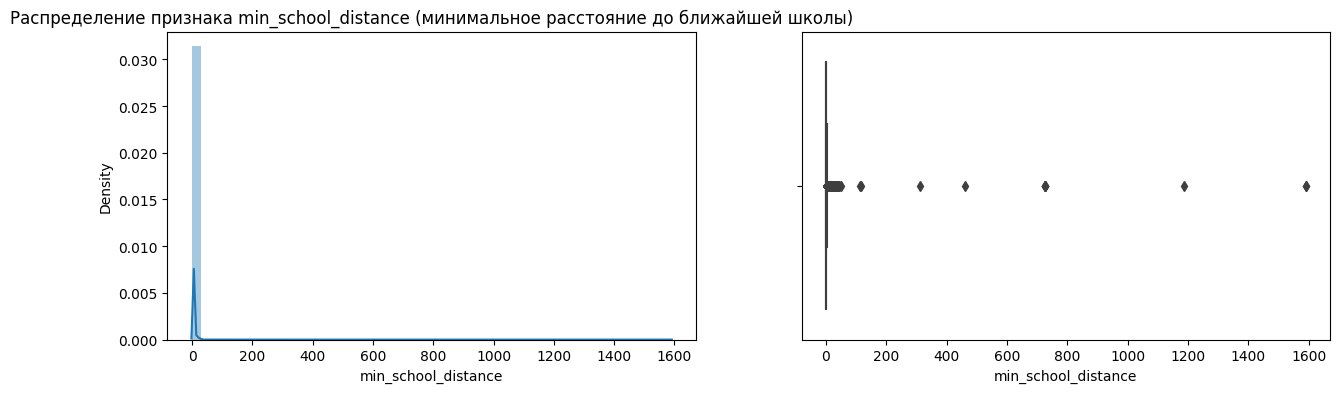

In [531]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
fig1 = sns.distplot(df['min_school_distance'], ax=axes[0])
fig1.set_title('Распределение признака min_school_distance (минимальное расстояние до ближайшей школы)')
sns.boxplot(data = df,
             x = 'min_school_distance', ax=axes[1])

Посмотрим, сколько объектов имеют количество ванн более 100

In [532]:
df[df['min_school_distance'] > 100].shape[1]

16

Всего 12 объектов. Удалим их:

In [533]:
df.drop(df[df['min_school_distance'] > 100].index, inplace=True)



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<AxesSubplot: xlabel='min_school_distance'>

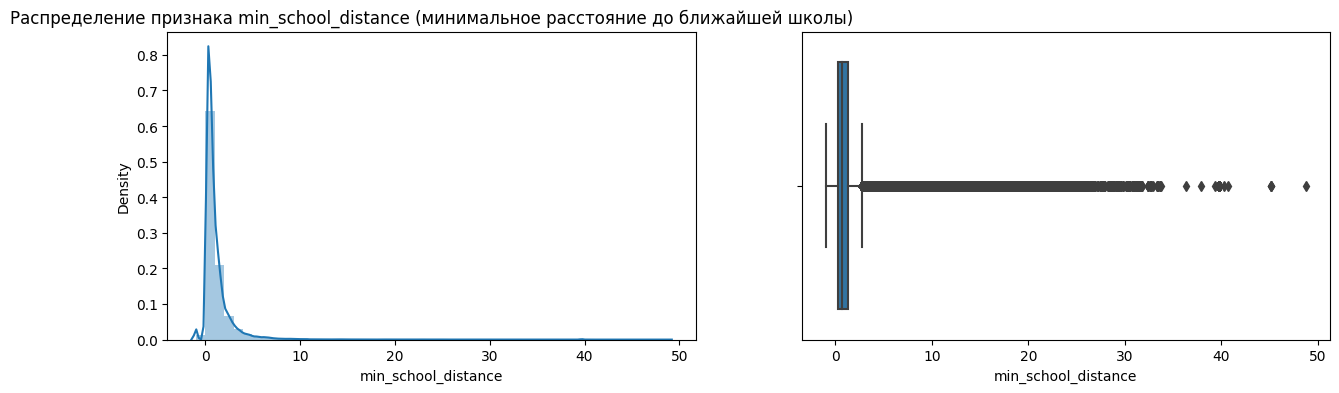

In [534]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
fig1 = sns.distplot(df['min_school_distance'], ax=axes[0])
fig1.set_title('Распределение признака min_school_distance (минимальное расстояние до ближайшей школы)')
sns.boxplot(data = df,
             x = 'min_school_distance', ax=axes[1])

Все-таки выбросы остались, попробуем ограничиться объектами со значением 'min_school_distance' <= 35 :

In [535]:
df.drop(df[df['min_school_distance'] > 35].index, inplace=True)



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<AxesSubplot: xlabel='min_school_distance'>

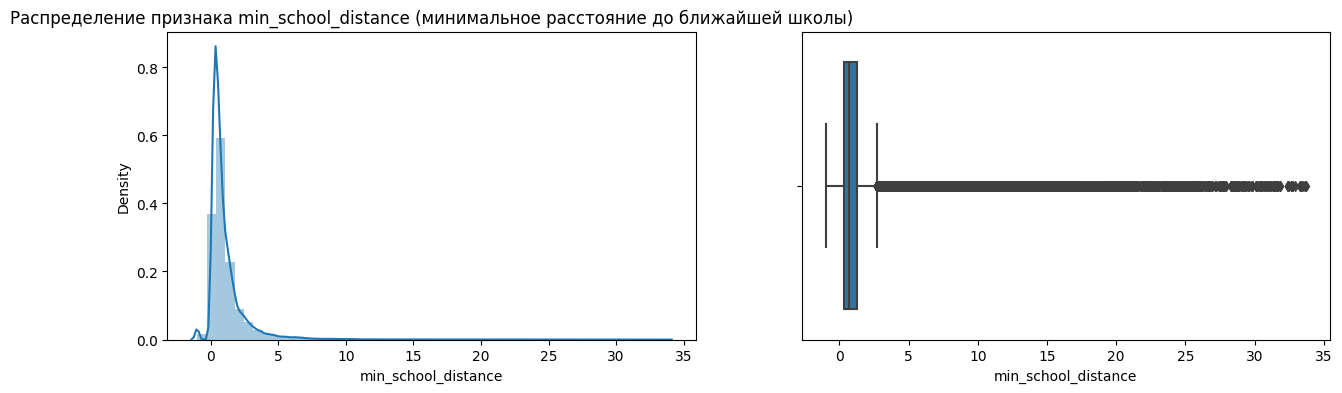

In [536]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
fig1 = sns.distplot(df['min_school_distance'], ax=axes[0])
fig1.set_title('Распределение признака min_school_distance (минимальное расстояние до ближайшей школы)')
sns.boxplot(data = df,
             x = 'min_school_distance', ax=axes[1])

### Выбросы в признаке 'sqft'



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<AxesSubplot: xlabel='sqft'>

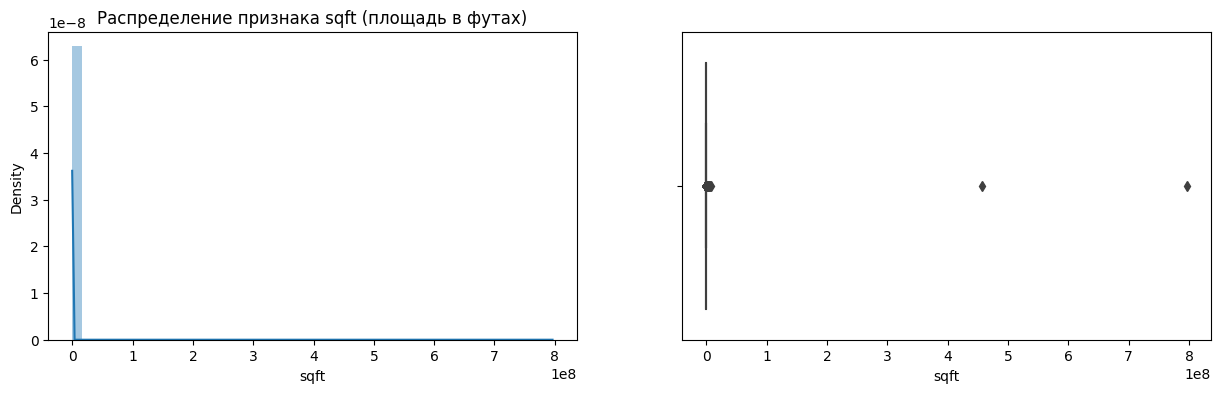

In [537]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
fig1 = sns.distplot(df['sqft'], ax=axes[0])
fig1.set_title('Распределение признака sqft (площадь в футах)')
sns.boxplot(data = df,
             x = 'sqft', ax=axes[1])

Очистим выбросы по методу интерквартильных расстояний, для этого создадим функцию outliers_iqr():

In [538]:
def outliers_iqr(data, feature, left = 1.5, right = 1.5):
    
    
    """Функция выявления выбросов по методу интерквартильных расстояний.
    Функция принимает на вход датасет, название признаков и правое и левое число интерквартильного размаха (по умолчанию 1.5)
    На выходе возвращает выбросы (outliers) и очищенный от выбросов датасет (cleaned_data)"""
    
    
    x = data[feature]
    quartile_1 = x.quantile(0.25)
    quartile_3 = x.quantile(0.75)
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - left * iqr
    upper_bound = quartile_3 + right * iqr
    outliers = data[(x <= lower_bound) | (x >= upper_bound)]
    cleaned_data = data[(x >= lower_bound) & (x <= upper_bound)]
    
    return outliers, cleaned_data



outliers, cleaned_data = outliers_iqr(df, 'sqft')
display(outliers.shape[0])

17824

In [539]:
df = cleaned_data



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<AxesSubplot: xlabel='sqft'>

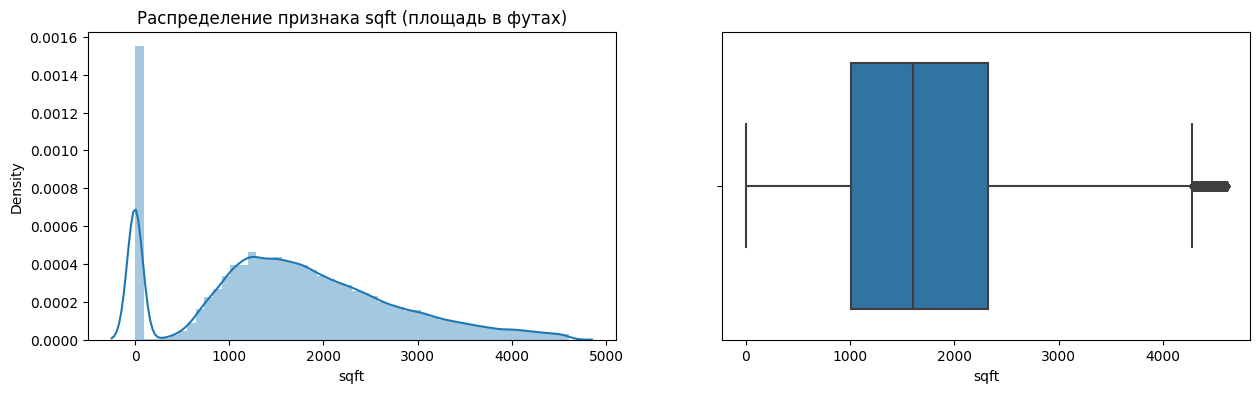

In [540]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
fig1 = sns.distplot(df['sqft'], ax=axes[0])
fig1.set_title('Распределение признака sqft (площадь в футах)')
sns.boxplot(data = df,
             x = 'sqft', ax=axes[1])

### Выбросы в признаке 'target'



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<AxesSubplot: xlabel='target'>

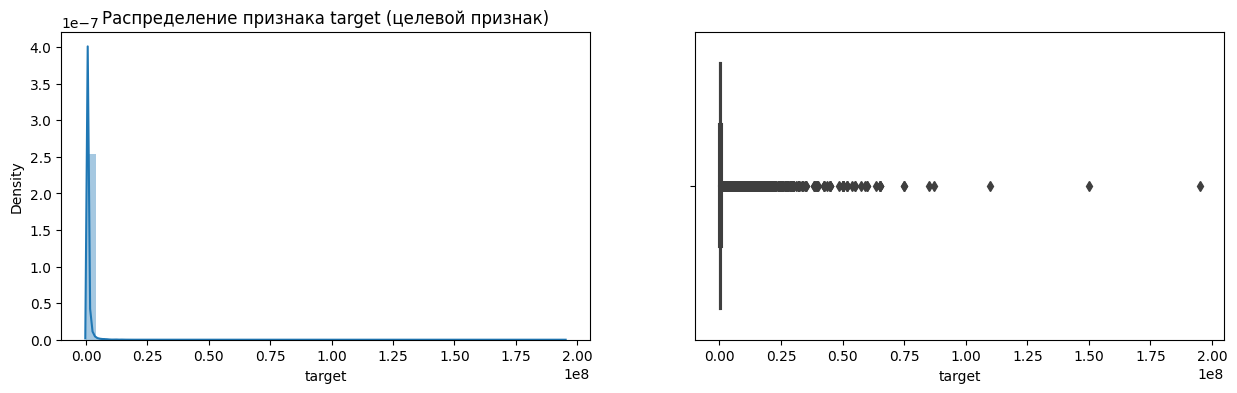

In [541]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
fig1 = sns.distplot(df['target'], ax=axes[0])
fig1.set_title('Распределение признака target (целевой признак)')
sns.boxplot(data = df,
             x = 'target', ax=axes[1])

Чтобы удалить выбросы также воспользумеся методом интерквартильных расстояний:

In [542]:
outliers, cleaned_data = outliers_iqr(df, 'target')
display(outliers.shape[0])

30082

In [543]:
df = cleaned_data



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<AxesSubplot: xlabel='target'>

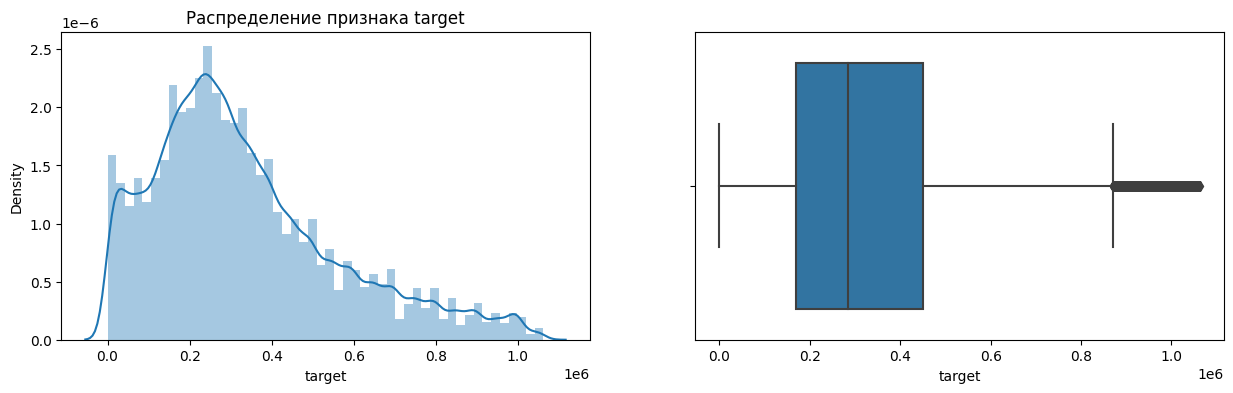

In [544]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
fig1 = sns.distplot(df['target'], ax=axes[0])
fig1.set_title('Распределение признака target')
sns.boxplot(data = df,
             x = 'target', ax=axes[1])

### Выбросы в признаке 'baths'



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<AxesSubplot: xlabel='baths'>

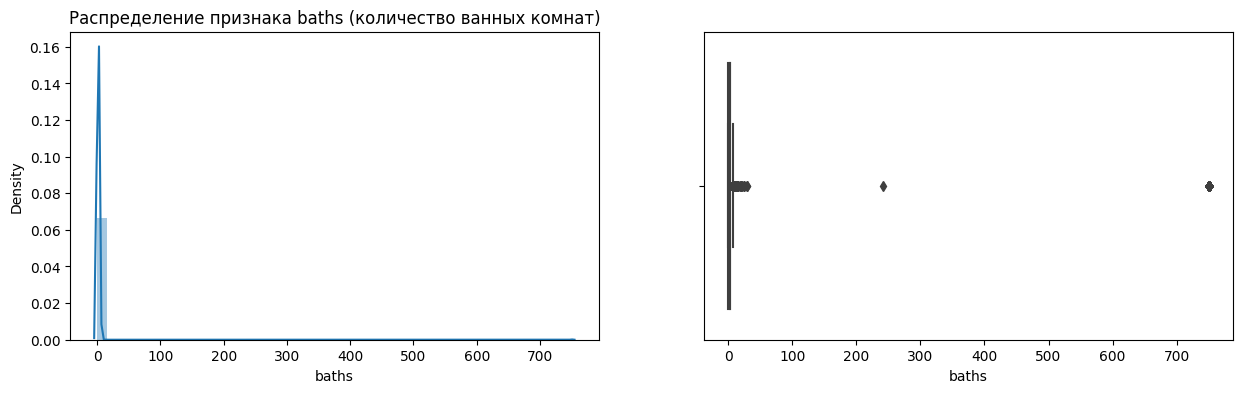

In [545]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
fig1 = sns.distplot(df['baths'], ax=axes[0])
fig1.set_title('Распределение признака baths (количество ванных комнат)')
sns.boxplot(data = df,
             x = 'baths', ax=axes[1])

Ограничимся объектами с количеством ванн < 200:

In [546]:
df = df[df['baths'] < 200]



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<AxesSubplot: xlabel='baths'>

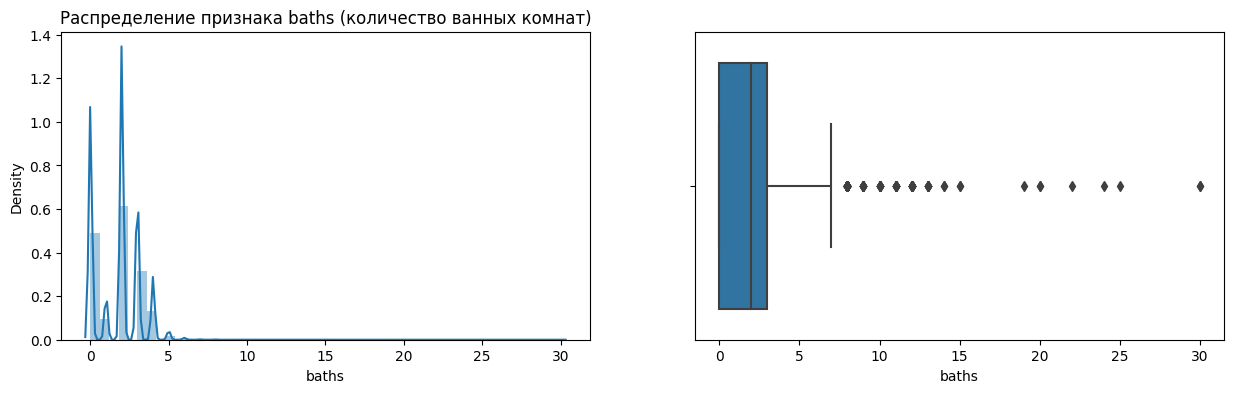

In [547]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
fig1 = sns.distplot(df['baths'], ax=axes[0])
fig1.set_title('Распределение признака baths (количество ванных комнат)')
sns.boxplot(data = df,
             x = 'baths', ax=axes[1])

In [548]:
df_cleaned = df.copy()

## Проверка на нормальность

Проверим, распределены ли данные 'target' нормально по критерию согласия Пирсона

<AxesSubplot: xlabel='target'>

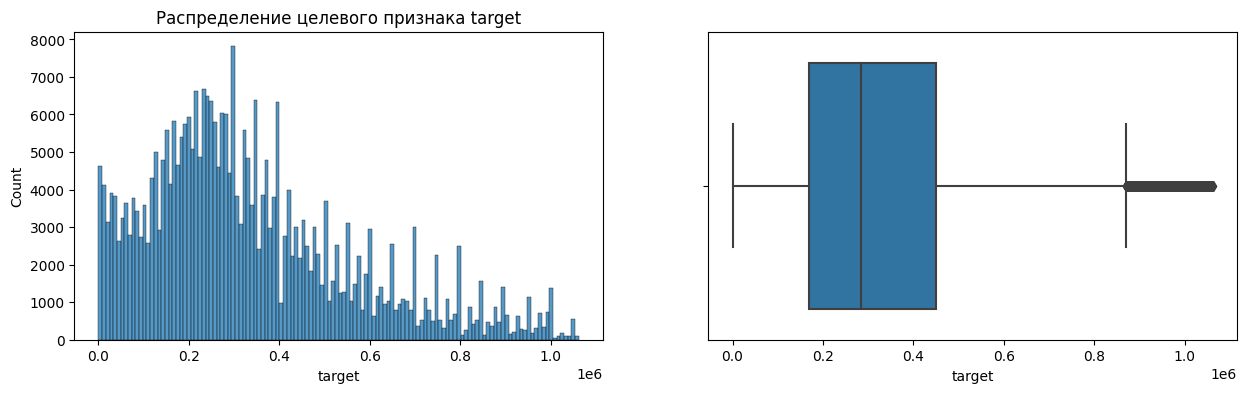

In [549]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
fig1 = sns.histplot(data = df,
             x = 'target', ax=axes[0])
fig1.set_title('Распределение целевого признака target')
sns.boxplot(data = df,
             x = 'target', ax=axes[1])

In [550]:
alpha = 0.05 #уровень значимости

H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'

_, p = normaltest(df['target'])
#normaltest возвращает двустороннюю вероятность для проверки гипотезы

print('p=%.3f' % p)

# Интерпретация 

if p > alpha/2:
	print(H0)
else:
	print(Ha)

p=0.000
Данные не распределены нормально (мы отвергаем H0)


Ислледуем логарифм целевого признака:

In [551]:
df['target_log'] = np.log(df['target'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [552]:

alpha = 0.05 #уровень значимости

H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'

_, p = normaltest(df['target_log'])
#normaltest возвращает двустороннюю вероятность для проверки гипотезы

print('p=%.3f' % p)

# Интерпретация 

if p > alpha/2:
	print(H0)
else:
	print(Ha)

p=0.000
Данные не распределены нормально (мы отвергаем H0)


In [553]:
df = df.drop('target_log', axis = 1)

## Проверка данных на коллинеарность

Проверим данные на мультиколлинеарность и взаимосвязь признаков с целевой переменной. Для этого построим матрицу корреляций. Дополним её тепловой картой, отражающей результат.

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<AxesSubplot: >

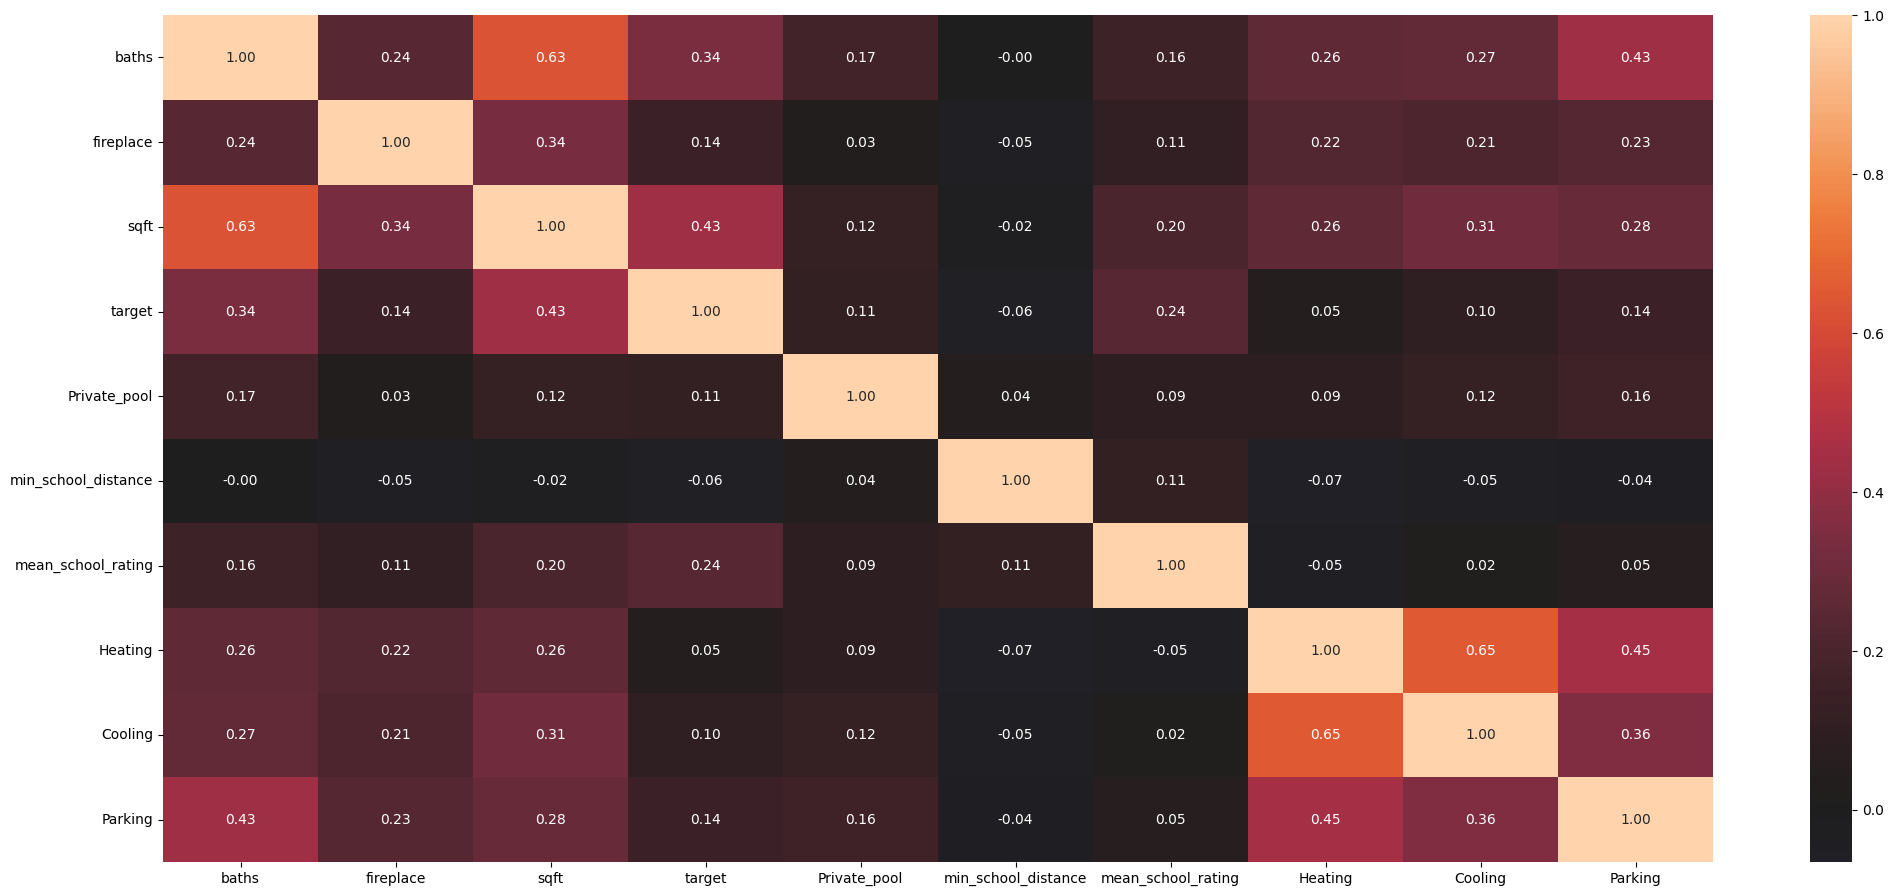

In [554]:
plt.figure(figsize=(25,11))  
sns.heatmap(df.corr(),fmt='.2f',annot=True, center=0)

Высокой корреляции нет, коллинеарность не наблюдается.

## Кодирование признаков

In [555]:
categorycal_features = ['status','propertyType','Year built','zipcode', 'city', 'state']

Необходимо закодировать категориальные признаки. Чтобы определиться с методом кодирование, посмотрим на количество уникальных значений признака.

In [556]:
for i in categorycal_features:
    print(i, data[i].nunique())

status 87
propertyType 13
Year built 221
zipcode 4538
city 1871
state 38


Количетсво уникальных значений во всех признаках более 10, чтобы не перегружать данные, воспользуемся бинарным кодировоанием.

In [557]:
for i in categorycal_features:
    bin_encoder = category_encoders.BinaryEncoder(df[i])
    bin_features = bin_encoder.fit_transform(df[i])
    df = pd.concat([df,bin_features], axis=1)

In [558]:
binary_encoder = category_encoders.BinaryEncoder(df['propertyType'])
propertyType_bin = binary_encoder.fit_transform(df['propertyType'])
df = pd.concat([df,propertyType_bin], axis=1)

In [559]:
df.head()

,status,propertyType,baths,fireplace,city,sqft,zipcode,state,target,Private_pool,...,state_0,state_1,state_2,state_3,state_4,state_5,propertyType_0,propertyType_1,propertyType_2,propertyType_3
0,active,single_family_home,4.0,1,southern pines,2900,28387,NC,418000.0,0,...,0,0,0,0,0,1,0,0,0,1
1,forsale,single_family_home,3.0,0,spokane valley,1947,99216,WA,310000.0,0,...,0,0,0,0,1,0,0,0,0,1
4,forsale,land,0.0,0,palm bay,-1,32908,FL,5000.0,0,...,0,0,0,0,1,1,0,0,1,0
5,forsale,townhouse,0.0,0,philadelphia,897,19145,PA,209000.0,0,...,0,0,0,1,0,0,0,0,1,1
6,active,other,0.0,0,poinciana,1507,34759,FL,181500.0,0,...,0,0,0,0,1,1,0,1,0,0


Удалим закодированные категориальные признаки.

In [560]:
df = df.drop(categorycal_features , axis = 1)

In [561]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320862 entries, 0 to 377184
Data columns (total 63 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   baths                320862 non-null  float64
 1   fireplace            320862 non-null  int64  
 2   sqft                 320862 non-null  int64  
 3   target               320862 non-null  float64
 4   Private_pool         320862 non-null  int64  
 5   min_school_distance  320862 non-null  float64
 6   mean_school_rating   320862 non-null  float64
 7   Heating              320862 non-null  int64  
 8   Cooling              320862 non-null  int64  
 9   Parking              320862 non-null  int64  
 10  status_0             320862 non-null  int64  
 11  status_1             320862 non-null  int64  
 12  status_2             320862 non-null  int64  
 13  status_3             320862 non-null  int64  
 14  status_4             320862 non-null  int64  
 15  status_5         

## Нормализация данных

Нормализуем числовые признаки 'sqft', 'min_school_distance', 'mean_school_rating', 'baths'

In [562]:
#scaler = StandardScaler()
scaler = RobustScaler()
#scaler = MinMaxScaler()

numeric_features = ['sqft', 'min_school_distance', 'mean_school_rating', 'baths']
for column in numeric_features:
       df[column] = scaler.fit_transform(df[[column]])[:,0]

In [563]:
df.head()

,baths,fireplace,sqft,target,Private_pool,min_school_distance,mean_school_rating,Heating,Cooling,Parking,...,state_0,state_1,state_2,state_3,state_4,state_5,propertyType_0,propertyType_1,propertyType_2,propertyType_3
0,0.666667,1,1.088020,418000.0,0,2.161290,0.198502,1,0,0,...,0,0,0,0,0,1,0,0,0,1
1,0.333333,0,0.311328,310000.0,0,0.344086,-0.250936,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,-0.666667,0,-1.276284,5000.0,0,2.516129,0.000000,0,0,0,...,0,0,0,0,1,1,0,0,1,0
5,-0.666667,0,-0.544417,209000.0,0,-1.817204,-2.123596,1,1,0,...,0,0,0,1,0,0,0,0,1,1
6,-0.666667,0,-0.047270,181500.0,0,0.118280,-0.876404,1,1,0,...,0,0,0,0,1,1,0,1,0,0


## Построение моделей

Разделим данные на тренировочную и тестовую в соотношении 80/20:

In [564]:
X = df.drop(['target'], axis=1)
y = df['target']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)


In [565]:

def metrics_сalculator(y_train, y_test, y_train_pred, y_test_pred, model):
    
    """Функция принимает на вход тренировочные и тестовые выборки ответов и предсказаний, а также название модели и 
    возвращает рассчитанные для них метрики RMSE и R^2"""
    
    
    rmse_train = metrics.mean_squared_error(y_train, y_train_pred, squared = False)
    rmse_test = metrics.mean_squared_error(y_test, y_test_pred, squared = False)
    
    r2_train = metrics.r2_score(y_train, y_train_pred)
    r2_test = metrics.r2_score(y_test, y_test_pred)
    
    d =  { 'Train RMSE':  round(rmse_train, 2), 'Test RMSE':  round(rmse_test, 3), 'Train R2':  round(r2_train, 3), 'Test R2':  round(r2_test, 2)}
    
         
    return d

### Модель линейной регрессии

Для начала построим простейшую модель линейной регрессии и рассчитаем для нее метрики.

In [566]:
model = LinearRegression(fit_intercept=False)

# вычисляем коэффициенты регрессии
model.fit(X_train, y_train)

# делаем предсказания с помощью модели
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [567]:
lr_dic = metrics_сalculator(y_train, y_test, y_train_pred, y_test_pred, LinearRegression)
lr_result = pd.DataFrame({' ': lr_dic.keys(),  'LinearRegression': lr_dic.values()})
lr_result

,,LinearRegression
0,Train RMSE,189629.57
1,Test RMSE,188950.90
2,Train R2,0.31
3,Test R2,0.31


## Модель дерева решений

Построим модель линейной регрессии на обучающей выборке. 

In [568]:
DTR = DecisionTreeRegressor(random_state=42)
DTR.fit(X_train, y_train)

DTR_y_train_pred = DTR.predict(X_train)
DTR_y_test_pred = DTR.predict(X_test)

In [569]:
DTR_dic = metrics_сalculator(y_train, y_test, DTR_y_train_pred, DTR_y_test_pred, DTR)
DTR_result = pd.DataFrame({' ': DTR_dic.keys(),  'DecisionTreeRegressor': DTR_dic.values()})
DTR_result

,,DecisionTreeRegressor
0,Train RMSE,21052.000
1,Test RMSE,155106.500
2,Train R2,0.991
3,Test R2,0.530


Как видим, значение метрики на валидационной выборке сильно отличается от метрики на тренировочной метрики, то есть наблюдаются признаки переобучения. Переберем все возможные варианты глубины дерева решений в диапазоне от 10 до 20.
Построим линейные графики изменения метрик R2 и RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений.

In [570]:
max_depths = np.arange(10, 20, 1)
#В цикле будем перебирать сгенерированные глубины
r2_test_scores = []
r2_train_scores = []
rmse_test_scores = []
rmse_train_scores = []

for depth in max_depths:
    desision_tree = DecisionTreeRegressor(random_state=42, max_depth=depth)
    desision_tree.fit(X_train, y_train)
    y_train_pred = desision_tree.predict(X_train)
    y_valid_pred = desision_tree.predict(X_test)
    r2_test = round((metrics.r2_score(y_test, y_valid_pred)), 3)
    r2_train =round((metrics.r2_score(y_train, y_train_pred)), 3)
    RMSE_test = round(np.sqrt(metrics.mean_squared_error(y_test, y_valid_pred)), 3)
    RMSE_train =round(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)), 3)
    #метрики добавляем в списки
    r2_test_scores.append(r2_test)
    r2_train_scores.append(r2_train)
    rmse_test_scores.append(RMSE_test)
    rmse_train_scores.append(RMSE_train)

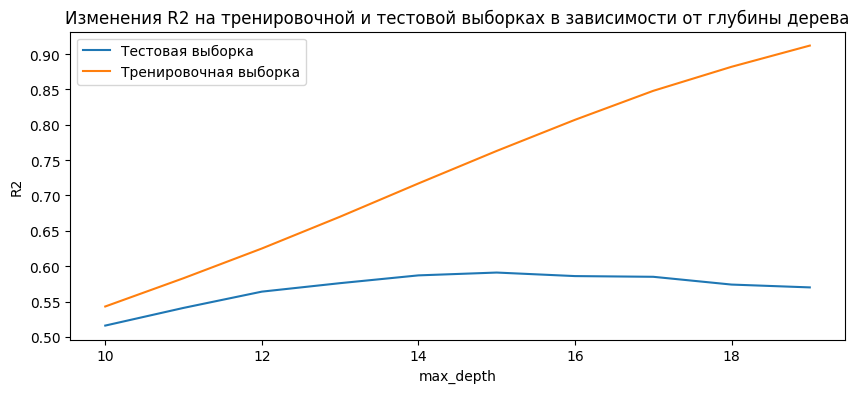

In [571]:
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости
ax.plot(max_depths, r2_test_scores, label='Тестовая выборка')
#Строим линейный график зависимости 
ax.plot(max_depths, r2_train_scores, label='Тренировочная выборка')

#Даем графику название и подписи осям
ax.set_title('Изменения R2 на тренировочной и тестовой выборках в зависимости от глубины дерева')
ax.set_xlabel('max_depth')
ax.set_ylabel('R2')
ax.legend()

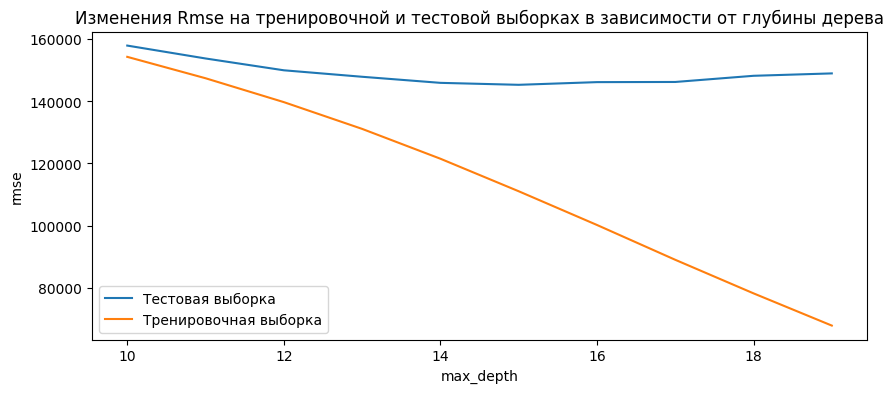

In [572]:
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости
ax.plot(max_depths, rmse_test_scores, label='Тестовая выборка')
#Строим линейный график зависимости 
ax.plot(max_depths, rmse_train_scores, label='Тренировочная выборка')

#Даем графику название и подписи осям
ax.set_title('Изменения Rmse на тренировочной и тестовой выборках в зависимости от глубины дерева')
ax.set_xlabel('max_depth')
ax.set_ylabel('rmse')
ax.legend()

Из графика видно, что оптимальная глубина дерева равна 15, тк при данной глубине наблюдается минимальное значение RMSLE на обучающей выборке, но при этом ещё не наблюдается переобучение (валидационная кривая ещё не начинает возрастать), а R2 на тестовой быборке максимально. Подставим данную глубину модель и посчитаем метрики.

In [573]:
desision_tree = DecisionTreeRegressor(random_state=42, max_depth=15)
desision_tree.fit(X_train, y_train)
dtopt_y_train_pred = desision_tree.predict(X_train)
dtopt_test_pred = desision_tree.predict(X_test)

In [574]:
DTR_dic = metrics_сalculator(y_train, y_test, dtopt_y_train_pred, dtopt_test_pred, desision_tree)
DTR_result = pd.DataFrame({'metric': DTR_dic.keys(),  'DecisionTreeRegressor': DTR_dic.values()})
DTR_result

,metric,DecisionTreeRegressor
0,Train RMSE,111073.640
1,Test RMSE,145273.077
2,Train R2,0.763
3,Test R2,0.590


Подобрав оптимальную глубину дерева удалось увеличить качество модели и снизить переобучение.

## Модель случайного леса

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. Начнем с модели случайного леса (RandomForestRegressor)

In [575]:
rfr = ensemble.RandomForestRegressor(max_depth=12,
                                  n_estimators=200,
                                  min_samples_split = 20,
                                  random_state=42,
                                    n_jobs = -1)

rfr.fit(X_train, y_train)

y_train_predict_rfr = rfr.predict(X_train)
y_test_predict_rfr = rfr.predict(X_test)

In [576]:
RFR_dic = metrics_сalculator(y_train, y_test, y_train_predict_rfr, y_test_predict_rfr, rfr)
RFR_result = pd.DataFrame({'metric': RFR_dic.keys(),  'RandomForestRegressor': RFR_dic.values()})
RFR_result

,metric,RandomForestRegressor
0,Train RMSE,130143.460
1,Test RMSE,137312.165
2,Train R2,0.675
3,Test R2,0.630


## Модель градиентного бустинга (GradientBoostingRegressor )

In [577]:
gbr = ensemble.GradientBoostingRegressor(learning_rate = 0.5,
                                         max_depth=6,
                                         n_estimators=100, #количество деревьев по-умолчанию
                                         min_samples_split = 30,
                                         random_state=42 #генератор случайных чисел
                                         )
gbr.fit(X_train, y_train)

y_train_predict_gbr = gbr.predict(X_train)
y_test_predict_gbr = gbr.predict(X_test)

In [578]:
GBR_dic = metrics_сalculator(y_train, y_test, y_train_predict_gbr, y_test_predict_gbr, gbr)
GBR_result = pd.DataFrame({'metric': GBR_dic.keys(),  'GradientBoostingRegressor': GBR_dic.values()})
GBR_result

,metric,GradientBoostingRegressor
0,Train RMSE,118112.800
1,Test RMSE,125268.422
2,Train R2,0.732
3,Test R2,0.700


## Модель CatBoostRegression

Передем к последней модели  - модели градиентного бустинга CatBoost. CatBoost позволяет использовать категориальные признаки без необходимости их предварительно обрабатывать.

При использовании CatBoost мы не должны пользоваться one-hot кодированием, поскольку это влияет на скорость обучения и на качество прогнозов. Вместо этого мы просто задаем категориальные признаки с помощью параметра cat_features. Поэтому будем использовать данные, очищенные от выбросов, но незакодированные (df_cleaned), посмотрим на них:

In [579]:
df_cleaned.head()

,status,propertyType,baths,fireplace,city,sqft,zipcode,state,target,Private_pool,min_school_distance,mean_school_rating,Year built,Heating,Cooling,Parking
0,active,single_family_home,4.0,1,southern pines,2900,28387,NC,418000.0,0,2.70,5.20,2019,1,0,0
1,forsale,single_family_home,3.0,0,spokane valley,1947,99216,WA,310000.0,0,1.01,4.00,2019,0,0,0
4,forsale,land,0.0,0,palm bay,-1,32908,FL,5000.0,0,3.03,4.67,No Data,0,0,0
5,forsale,townhouse,0.0,0,philadelphia,897,19145,PA,209000.0,0,-1.00,-1.00,1920,1,1,0
6,active,other,0.0,0,poinciana,1507,34759,FL,181500.0,0,0.80,2.33,2006,1,1,0


Нормализуем числовые данные ('sqft', 'min_school_distance', 'mean_school_rating', 'baths'):

In [580]:
scaler = RobustScaler()
#scaler = MinMaxScaler()

numeric_features = ['sqft', 'min_school_distance', 'mean_school_rating', 'baths']
for column in numeric_features:
       df_cleaned[column] = scaler.fit_transform(df_cleaned[[column]])[:,0]

Разделим выборку на обучающую и тестовую в соотношении (80/20). CatBoost использует специальный объект Pool для представления данных. Создадим Pool, указав признаки, целевую переменную и категориальные признаки. Далее инициализуем модель:

In [581]:
X = df_cleaned.drop(['target'], axis=1)
y = df_cleaned['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)
categorial_features = ['status', 'propertyType', 'city', 'zipcode', 'state', 'Year built']

train_pool = Pool(X_train, label=np.log(y_train + 1), cat_features=categorial_features)
val_pool = Pool(X_test, label=np.log(y_test + 1), cat_features=categorial_features)


# Инициализация модели
CBR = CatBoostRegressor(
    iterations = 1500,
    #depth=10,
    #learning_rate = 0.5,
    random_seed = 42,
    eval_metric='RMSE',
    custom_metric = 'R2',
    od_wait=500,
    #task_type='GPU',
)
# Fit
CBR.fit(
    train_pool,
    eval_set=val_pool,
    verbose_eval=100,
    use_best_model=True,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.095007
0:	learn: 0.9523728	test: 0.9520007	best: 0.9520007 (0)	total: 166ms	remaining: 4m 8s
100:	learn: 0.5040593	test: 0.4914244	best: 0.4914244 (100)	total: 7.03s	remaining: 1m 37s
200:	learn: 0.4799406	test: 0.4698545	best: 0.4698545 (200)	total: 14.2s	remaining: 1m 31s
300:	learn: 0.4678902	test: 0.4591975	best: 0.4591975 (300)	total: 21.3s	remaining: 1m 24s
400:	learn: 0.4605379	test: 0.4536049	best: 0.4536049 (400)	total: 28.6s	remaining: 1m 18s
500:	learn: 0.4548039	test: 0.4494203	best: 0.4494203 (500)	total: 35.9s	remaining: 1m 11s
600:	learn: 0.4502731	test: 0.4462479	best: 0.4462479 (600)	total: 43.2s	remaining: 1m 4s
700:	learn: 0.4466122	test: 0.4439184	best: 0.4439184 (700)	total: 50.4s	remaining: 57.5s
800:	learn: 0.4431451	test: 0.4415891	best: 0.4415891 (800)	total: 57.9s	remaining: 50.5s
900:	learn: 0.4403873	test: 0.4399678	best: 0.4399678 (900)	total: 1m 5s	remaining: 43.5s
1000:	learn: 0.4380646	test: 0.4385029	best: 0.4385029 (1000)	total: 

In [582]:
y_train_predict_cbr = np.exp(CBR.predict(X_train)) - 1
y_test_predict_cbr = np.exp(CBR.predict(X_test)) - 1
CBR_dic = metrics_сalculator(y_train, y_test, y_train_predict_cbr, y_test_predict_cbr, rfr)


In [583]:
CBR_result = pd.DataFrame({'metric': CBR_dic.keys(),  'CatBoostRegressor': CBR_dic.values()})
CBR_result

,metric,CatBoostRegressor
0,Train RMSE,109518.270
1,Test RMSE,114095.486
2,Train R2,0.770
3,Test R2,0.750


Построим диаграмма shap для выявлении важных взаимоотношений между признаками и прогнозами модели. На нашей диаграмме признаки упорядочены по их средним SHAP‑значениям.

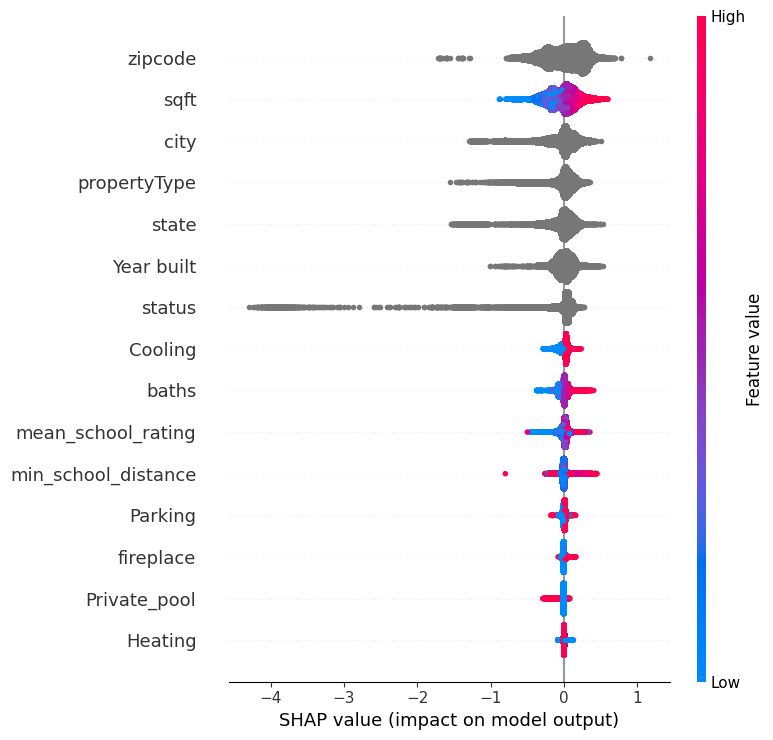

In [584]:

inspected_model = CBR
X = pd.concat([X_train, X_test], axis=0)

explainer = shap.TreeExplainer(inspected_model)
shap_values = explainer.shap_values(X)

# summarize the effects of all the features
shap.summary_plot(shap_values, X)

Исследуя SHAP‑значения на этой диаграмме, мы можем начать понимать природу взаимоотношений между признаками и спрогнозированными ценами объектов недвижисомти. В случае с числовыми признаками Sqft, baths, min_school_distance, mean_school_rating видно, что SHAP‑значения растут по мере роста значения признака. Это указывает на то, что более высокие значения Sqft, baths, min_school_distance, mean_school_rating соответствуют более высоким спрогнозированным ценам объектов. Категориальные признаки окрашены в серый.

## Итоги и сравнение результатов

Для предсказания цены недвижимости были построены 5 моделей:
- *LinearRegression* - Baseline
- *DecisionTreeRegressor*
- *RandomForestRegressor*
- *GradientBoostingRegressor*
- *CatBoostRegressor*

Для оценки эффективности моделей использовались коэффициент детерминации (R2) и среднеквадратичная ошибка (RMSE). Выведем и сравним результаты.

In [585]:
results_comparison = pd.concat([lr_result, DTR_result, RFR_result, GBR_result, CBR_result], axis = 1).drop(['metric'], axis = 1)
results_comparison

,,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,CatBoostRegressor
0,Train RMSE,189629.57,111073.640,130143.460,118112.800,109518.270
1,Test RMSE,188950.90,145273.077,137312.165,125268.422,114095.486
2,Train R2,0.31,0.763,0.675,0.732,0.770
3,Test R2,0.31,0.590,0.630,0.700,0.750


Как видим, наилучший результат показала модель градиентного бустинга с CatBoostRegressor (R2 = 0.75, RMSE=114095). Также неплохой результат у модели GradientBoostingRegressor (R2 = 0.7, RMSE=125272).
В рамках проекта удалось погрузиться в проект и пройти поэтапно цикл от предобработки данных до построения и оценки моделей регресии для предсказания целевого признака. БОльшую часть времени у меня занял этап предобработки признаков.

## Подготовка модели к продакшену

In [586]:
df_cleaned.head()

,status,propertyType,baths,fireplace,city,sqft,zipcode,state,target,Private_pool,min_school_distance,mean_school_rating,Year built,Heating,Cooling,Parking
0,active,single_family_home,0.666667,1,southern pines,1.088020,28387,NC,418000.0,0,2.161290,0.198502,2019,1,0,0
1,forsale,single_family_home,0.333333,0,spokane valley,0.311328,99216,WA,310000.0,0,0.344086,-0.250936,2019,0,0,0
4,forsale,land,-0.666667,0,palm bay,-1.276284,32908,FL,5000.0,0,2.516129,0.000000,No Data,0,0,0
5,forsale,townhouse,-0.666667,0,philadelphia,-0.544417,19145,PA,209000.0,0,-1.817204,-2.123596,1920,1,1,0
6,active,other,-0.666667,0,poinciana,-0.047270,34759,FL,181500.0,0,0.118280,-0.876404,2006,1,1,0


Создадим пайплан для ускорение вычислений с использованием многопоточности в Python и дальнейшее развертывание пайплайна для использования в периодических расчетах:

In [587]:


ct = make_column_transformer(
     (BinaryEncoder(), ['status','propertyType','Year built','zipcode', 'city', 'state']),
      (RobustScaler(), ['sqft', 'min_school_distance', 'mean_school_rating', 'baths'])
      )

pipe = Pipeline([  
 ('ct', ct),
  ('GradientBoostingRegressor', gbr)
  ])


In [588]:
X = df_cleaned.drop(['target'], axis=1)
y = df_cleaned['target']
cols = df_cleaned.drop(['target'],axis=1).columns

In [589]:
pipe.fit(X, y)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('binaryencoder',
                                                  BinaryEncoder(),
                                                  ['status', 'propertyType',
                                                   'Year built', 'zipcode',
                                                   'city', 'state']),
                                                 ('robustscaler',
                                                  RobustScaler(),
                                                  ['sqft',
                                                   'min_school_distance',
                                                   'mean_school_rating',
                                                   'baths'])])),
                ('GradientBoostingRegressor',
                 GradientBoostingRegressor(learning_rate=0.5, max_depth=6,
                                           min_samples_split=30,
                                           random_state=42))])

Далее, когда мы получили обученную модель, нам необходимо сериализовать её, превратив объект Python в поток байтов. Для этого импортируем модуль pickle и воспользуемся функцией dumps(), в которую нужно передать объект Python:

In [590]:
with open('pipeline.pkl', 'wb') as output:
    pickle.dump(pipe, output)

Попробуем восстановить (десериализовать) объект Python:

In [591]:
with open('pipeline.pkl', 'rb') as pkl_file:
    loaded_pipe = pickle.load(pkl_file)

In [595]:
# сделаем предсказание
request = ['active', 'single family', 2, 1, 'southern pines', 3000, 28387, 0, 'NC', 30, 4, 2019, 1, 0, 0]
req = pd.DataFrame([request], columns=cols)
prediction = loaded_pipe.predict(req)
prediction

array([1121997.56564538])

## Продакшн

In [594]:
!pip freeze > requirements.txt

При помощи flask создадим рабочий прототип модели, который работает на веб-сервисе и умеет выдавать предсказания в ответ на POST-запросы клиентов. Файла сервера (server_ml.py) и клиента (client_ml.py) прилагаются 